In [1]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from ferrosim import Ferro2DSim
# import torch
import joblib
from joblib import Parallel, delayed, parallel_backend
import time
np.random.seed(512)
import pandas as pd
# from sklearn.model_selection import train_test_split
from scipy.stats import halfnorm, norm
import pickle

import gpax
import jax.numpy as jnp
gpax.utils.enable_x64()
import jax

/nfs/home/svalleti/anaconda3/envs/ferrosim/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Defining Neural network in Haiku, this acts as the encoder for DKL
import haiku as hk

class customMLP(hk.Module):
    """Simple MLP"""
    def __init__(self, embedim=2):
        super().__init__()
        self._embedim = embedim

    def __call__(self, x):
        x = hk.Linear(128)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(128)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self._embedim)(x)
        return x

In [3]:
# We can also use 1D convolutional in place of FCNN as the encoder
# This helps in better encoding with fewer parameters
class CustomCNN(hk.Module):
    def __init__(self, embedim = 2, name=None):
        super().__init__(name=name)
        self._embedim = embedim

    def __call__(self, x):
        # x shape should be (batch_size, 900, 1) where 1 is the number of channels
        x = hk.Conv1D(output_channels=8, kernel_shape=3, stride=1, padding='SAME')(x)
        x = jax.nn.relu(x)
        x = hk.MaxPool(window_shape=2, strides=2, padding='VALID')(x)
        
        x = hk.Conv1D(output_channels=16, kernel_shape=3, stride=1, padding='SAME')(x)
        x = jax.nn.relu(x)
        x = hk.MaxPool(window_shape=2, strides=2, padding='VALID')(x)
        
        x = hk.Conv1D(output_channels=32, kernel_shape=3, stride=1, padding='SAME')(x)
        x = jax.nn.relu(x)
        x = hk.MaxPool(window_shape=2, strides=2, padding='VALID')(x)
        
        # Flatten the output
        x = hk.Flatten()(x)
        
        # Fully connected layer to the desired number of output neurons
        # x = hk.Linear(32)(x)
        # Fully connected layer to the desired number of output neurons
        x = hk.Linear(self._embedim)(x)
        return x

In [4]:
# Class for Genetic Algorithm 

class GA():
    def __init__(self, inputs, outputs_abs, dkl, key, gen_array):
        self.inputs = inputs
        self.outputs_abs = outputs_abs
        self.dkl = dkl
        self.key = key
        self.gen_array = gen_array
    
    def crossover(self, idx1, idx2):
        # Method to perform arithemetic crossover given two parents (par1 and par2)
        # chld1 = lambda * par1 + (1-lambda) * par2
        # chld2 = (1-lambda) * par1 + lambda * par2
        
        par1 = self.inputs[idx1]
        par2 = self.inputs[idx2]
        weight = np.random.uniform(0.15, 0.85) 
        chld1 = (weight*par1) + ((1-weight)*par2)
        chld2 = ((1-weight)*par1) + (weight*par2)
        
        return chld1, chld2, weight
    
    def mutation(self, idx):
        # Method to peform mutation
        # Adds or subtracts a Gaussian distribution with a randomly selected mean and standard deviation
        
        par = self.inputs[idx]
        mu  = np.random.choice(np.arange(100, 800))
        std = halfnorm.rvs(loc = 50, scale = 150)
        pdf = norm.pdf(np.arange(900), mu, std)
        factor = np.random.choice([-1,1])
        weight = (np.random.rand()*100)+50
        chld = par+(weight*factor*pdf)

        return chld, mu, std

    def make_next_gen(self, P = [0.5, 0.5], policy = 'thompson'):

        # Method to form the next generation of the genetic algorithm
        # P is the list of porbabilitiesto perform GA operations, Currently we are only performing crossover...
        # ... and mutation and hence it is a list with two items summing to 1.

        
        # 15% of the fittest curves are carried to the next generation directly
        # The rest 85% curves are formed by performing operations governed by P where the curves are picked...
        # ... with a likelihood proportional to the fitness function

        if policy == 'thompson':
            seed = np.random.randint(0, 10000)  # This is an example; manage seeds appropriately
            new_key = jax.random.PRNGKey(seed)
            fitness = np.array(self.dkl.sample_from_posterior(new_key, self.inputs, n = 1)[1][0])
            fitness[fitness<0] = 0
            variable_fitness = True
        elif policy == 'mean':
            fitness, _ = np.array(self.dkl.predict(self.key, self.inputs))
            fitness[fitness<0] = 0
            variable_fitness = False
        elif policy == 'variance':
            _, fitness = np.array(self.dkl.predict(self.key, self.inputs))
            fitness[fitness<0] = 0
            variable_fitness = False

        
        num_carry_frwd = int(0.15*len(fitness))
        
        sorted_inds = np.argsort(fitness)[::-1]
        nextgen_X = self.inputs[sorted_inds[0:num_carry_frwd]]
        nextgen_abs = self.outputs_abs[sorted_inds[0:num_carry_frwd]]
        nextgen_gens = self.gen_array[sorted_inds[0:num_carry_frwd]]

        # picked_inds = np.random.choice(np.arange(len(self.inputs)), 
        #                                replace = True, p = self.fitness/np.sum(self.fitness), size = 950)
        
        # Identify the current generations
        current_gen = np.max(self.gen_array) + 1

        num_new_chld = len(fitness) - num_carry_frwd
        
        j = 0
        while j < num_new_chld:
            operator = np.random.choice([0, 1], p = P)
            if operator == 0:
                # Here goes crossover with 2 indices

                if variable_fitness:
                    seed = np.random.randint(0, 10000)  # This is an example; manage seeds appropriately
                    new_key = jax.random.PRNGKey(seed)
                    fitness = np.array(self.dkl.sample_from_posterior(new_key, self.inputs, n = 1)[1][0])
                    fitness[fitness<0] = 0
                
                picked_inds = np.random.choice(np.arange(len(self.inputs)), 
                                       replace = False, p = fitness/np.sum(fitness), size = 2)
                new1, new2, _ = ga.crossover(picked_inds[0], picked_inds[1])
                nextgen_X = np.append(nextgen_X, new1[None], axis = 0)
                nextgen_X = np.append(nextgen_X, new2[None], axis = 0)
                
                nextgen_abs = np.append(nextgen_abs, [np.nan, np.nan])
                nextgen_gens = np.append(nextgen_gens, [current_gen, current_gen])
                
                j+=2
            elif operator == 1:
                # Here goes the mutation

                if variable_fitness:
                    seed = np.random.randint(0, 10000)  # This is an example; manage seeds appropriately
                    new_key = jax.random.PRNGKey(seed)
                    fitness = np.array(self.dkl.sample_from_posterior(new_key, self.inputs, n = 1)[1][0])
                    fitness[fitness<0] = 0
                
                picked_inds = np.random.choice(np.arange(len(self.inputs)), 
                                       replace = False, p = fitness/np.sum(fitness), size = 1)
                new, _, _ = self.mutation(picked_inds[0])
                nextgen_X = np.append(nextgen_X, new[None], axis = 0)
                nextgen_abs = np.append(nextgen_abs, np.nan)
                nextgen_gens = np.append(nextgen_gens, np.array(current_gen))

                j+=1

        return nextgen_X, nextgen_abs, nextgen_gens

In [5]:
# Function to query the physical system
# AKA running the simulation on a given gene to obtain the corresponding target function value
def runferrosim(i, X, fmul = 150):
    applied_field = np.zeros([len(t_vec_ext),2])
    applied_field[0:900,0] = fmul*X[i]
    applied_field[900::,0] = applied_field[899, 0]
    sim = Ferro2DSim(n=20, time_vec = t_vec_ext, appliedE= applied_field,
                 defects=defect_list, 
                 mode = 'tetragonal', init = 'pr', k=100.0, dep_alpha = 0.3)
    sim.runSim()
    curl = np.sum(np.abs(sim.calc_curl(sim.getPmat(time_step = -1))))
    # pmat = sim.getPmat(time_step = -1)
    # np.sum(np.abs(sim.calc_curl(pmats_total[i])))
    
    del sim
    return curl

# Generation-0

The initial generation is part of of previous papers:  
1) https://doi.org/10.1088/2632-2153/ad1a4f  
2) https://doi.org/10.1039/D2DD00065B   


Instead of running the simulations here for the entire generation, we load the inputs, corresponding target function values and the necessary files to reproduce the simulation


In [6]:
dataset = np.load('dataset.npy')   # 7,500 electric fields, the generation of these will be discussed below
curls = np.load('curls.npy')   # Polarization matrices at the end of FerroSIM simulations for the electric fields downloaded
defects = np.load('defect_list_seed.npy')   # Defects used in ferroSIM simulations
defect_list = list(defects)

t_vec_dummy = np.linspace(0,4,1200)
t_vec = t_vec_dummy[0:900]  #Time used in rvae  
t_vec_ext = t_vec_dummy[0:950]    #Time used in ferrosim

In [7]:
applied_field = np.zeros([len(t_vec_ext),2])
applied_field[0:900,0] = 150*dataset[512]
applied_field[900::,0] = applied_field[899, 0]   #Adding the equilibration region
np.random.seed(512)
sim = Ferro2DSim(n=20,    #Lattice size 
                 time_vec = t_vec_ext,   #Time Vector
                 appliedE= applied_field,   # Applied electric field in x and y directons
                 defects=defect_list,       # Any list of defects
                 mode = 'tetragonal',       #Mode of the free energy equations to be used, refer: https://github.com/ramav87/FerroSim/blob/rama_dev_updated/equations.docx
                 init = 'pr',       #Initialization mode, random initialization might not cause reproducibility and hence all the lattice sites are initialized to a constant value
                 k=100.0,         # coupling constant, K = k/8, where K is the coupling constant in the free energy equation
                 dep_alpha = 0.3  #Depolarization constant
                 )

sim.runSim()

---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:22<00:00, 42.53it/s]


{'Polarization': array([[   0.        ,   46.69407778,   57.63946765, ..., -225.33271619,
         -225.3687708 , -225.40668959],
        [   0.        ,    0.73501264,    0.95061945, ...,    8.7476161 ,
            8.7295951 ,    8.70882211]]),
 'dPolarization': array([[    0.        , 13996.54981398, 13778.29297494, ...,
           -62.62556612,   -59.33408458,   -55.45454149],
        [    0.        ,   220.32003826,   209.45607462, ...,
           -27.75449769,   -27.04330938,   -25.89016839]])}

Text(0.5, 1.0, '7500 datapoints')

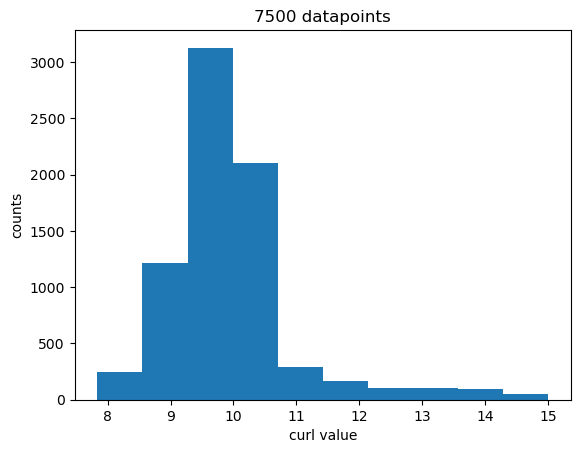

In [8]:
# Curls distribution of the entire dataset
plt.hist(curls)
plt.xlabel('curl value')
plt.ylabel('counts')
plt.title('7500 datapoints')

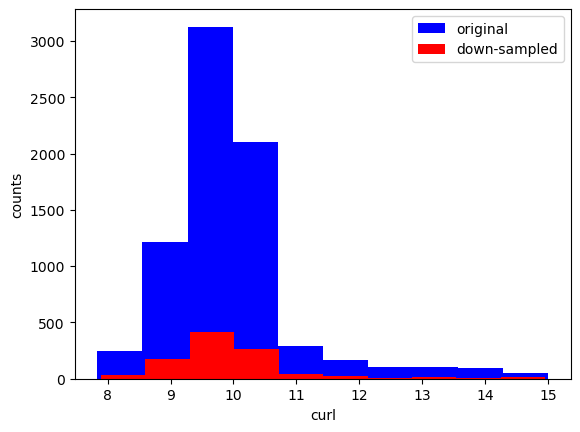

In [9]:
np.random.seed(512)
dummy = np.random.choice(np.arange(len(dataset)), size = 1000, replace = False)
X0 = np.copy(dataset)[dummy]
y0_abs = np.copy(curls)[dummy]

plt.hist(curls, color = 'b', label = 'original')
plt.hist(y0_abs, color = 'r', label = 'down-sampled')
plt.xlabel('curl')
plt.ylabel('counts')
plt.legend()

In [10]:
# Here we run the DKL on a randomly selected dataset of 200 datapoints
rng_key_0, rng_key_predict_0 = gpax.utils.get_keys()
dkl_BO_0 = gpax.viDKL(900, 2, 'RBF')
np.random.seed(512)
train_inds = np.random.choice(np.arange(len(X0)), size = 200, replace = False)
dkl_BO_0.fit(rng_key_0, X0[train_inds], y0_abs[train_inds], nn = CustomCNN, num_steps = 10000, step_size = 5e-4)


100%|█| 10000/10000 [01:59<00:00, 84.02it/s, init loss: 62999.5208, avg. loss [9



Inferred GP kernel parameters
k_length         [3.8065 2.8434]
k_scale          12.2779
noise            0.012700000000000001


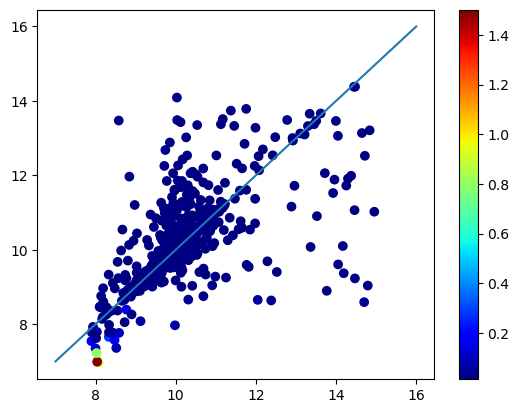

In [11]:
# Predictions of DKL on the entire dataset
preds, preds_stds = dkl_BO_0.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            rng_key_predict_0, X0, batch_size=20)
plt.scatter(y0_abs, preds, c = preds_stds, cmap = 'jet')
plt.colorbar()
plt.plot(np.linspace(7, 16, 100), np.linspace(7, 16, 100))


# Here we use the DKL network trained on 200 datapoints out of 7500 as the proxy to predict target function values for the entire dataset. These proxies are then fed to the Genetic Algorithm to make the next generation of genes.

In [12]:
pred_mean, pred_std = dkl_BO_0.predict(rng_key_predict_0, X0)

In [13]:
gens0 = np.zeros(len(X0))
ga = GA(X0, y0_abs, dkl_BO_0, rng_key_predict_0, gens0)
# import time
# tic = time.time()
# inps, outs, genss = ga.make_next_gen()  # Making next generation curves
# print(time.time()-tic)

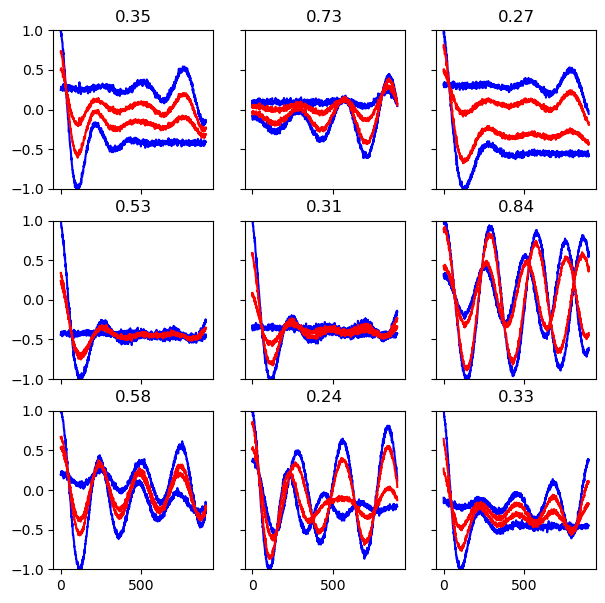

In [14]:
# Examples of Arithemetic Crossover
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (7,7))

np.random.seed(512)
dummy_inds = np.random.choice(np.arange(len(X0)), size = 18)

for i, ax in enumerate(ax.flat):
    id1, id2 = dummy_inds[2*i], dummy_inds[2*i+1] 
    ax.plot(X0[id1], c = 'b')
    ax.plot(X0[id2], c = 'b')
    child1, child2, weight = ga.crossover(id1, id2)
    ax.plot(child1, c = 'r')
    ax.plot(child2, c = 'r')
    ax.set_ylim(-1, 1)
    ax.set_title("{:.2f}".format(weight))
    # ax.set_title(str(i))
    if i not in  [0, 3, 6]:
        ax.set_yticklabels([]) # x-axis
    if i not in  [6, 7, 8]:
        ax.set_xticklabels([]) # y-axis
# ax[0].set_xticklabels([]) # y-axis

# plt.savefig('Crossover_examples.png', dpi = 300)


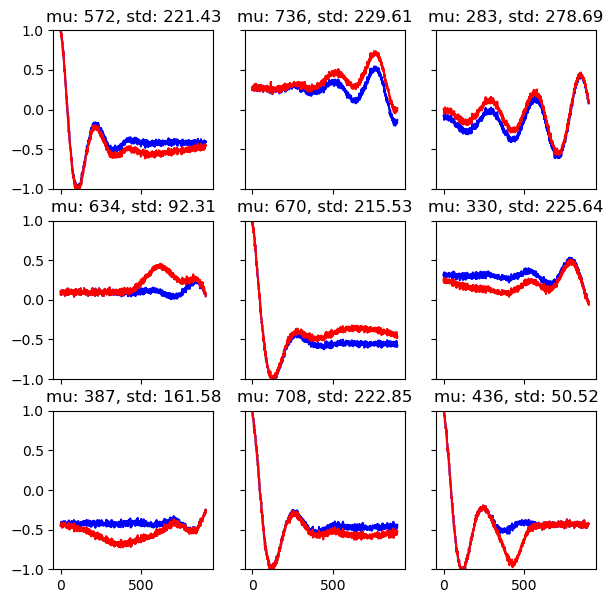

In [16]:
# Examples of mutation

fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (7,7))
np.random.seed(512)
dummy_inds = np.random.choice(np.arange(len(X0)), size = 9)

for i, ax in enumerate(ax.flat):
    id = dummy_inds[i]
    ax.plot(X0[id], c = 'b')
    
    child, mu, std = ga.mutation(id)
    ax.set_ylim(-1, 1)
    ax.plot(child, c = 'r')
    ax.set_title('mu: {}, std: {:.2f}'.format(mu, std))
    if i not in  [0, 3, 6]:
        ax.set_yticklabels([]) # x-axis
    if i not in  [6, 7, 8]:
        ax.set_xticklabels([]) # y-axis

# plt.savefig('Mutation_examples (with weights).png', dpi = 300)
    

# Future Generations
--Running the GA for 40 generations where DKL only queries a tiny proportion of a given generation and predicts the target function of the rest of the genes. The inputs to be queried are selected based on an active learning loop run by DKL with a given acquisition funciton.  

--The data in each generation is saved to evaluate the performance of the algorithm at a later stage.  
--This upcoming cell takes a long time even with parallelism on multiple CPU cores, hence the dataset is loaded in the next cell to visualize the results circumventing the need for running the entire algorithm.


In [29]:
gens_arr = np.zeros(len(X0))
inputs, outputs_abs = X0, y0_abs
dkl_BO, pred_key = dkl_BO_0, rng_key_predict_0
data_gens = {}
niter = 40


for iter in range(niter):
    
    ga = GA(inputs, outputs_abs, dkl_BO, pred_key, gens_arr)

    inputs, outputs_abs, gens_arr = ga.make_next_gen(policy = 'thompson')  # Making next generation curves

    # Initialization for the DKL algorithm

    idx = np.where(~np.isnan(outputs_abs))[0]   # Here we will use the curves from the previous generation as the initialization step

    print("The number of intialization points in generation-", iter+1, len(idx))
          
    inputs_train = inputs[idx]
    inputs_unmeasured = np.delete(inputs, idx, axis=0)
    
    indices_total = np.arange(len(inputs))
    indices_train = indices_total[idx]
    y_train = outputs_abs[idx]
    indices_unmeasured = np.delete(indices_total, idx)

    exploration_steps = 10
    for e in range(exploration_steps):
        print("\nStep {}".format(e+1))
        # Obtain/update DKL posterior
        rng_key, pred_key = gpax.utils.get_keys()
        dkl_BO = gpax.viDKL(900, 2, 'RBF')
        dkl_BO.fit(rng_key, inputs_train, y_train, nn = CustomCNN, num_steps = 10000, step_size = 5e-4)
        # Compute acqusition function
        y_mean, y_var = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            pred_key, inputs_unmeasured, batch_size=250)
        y_std = jnp.sqrt(y_var)
        obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    
        sort = np.argsort(obj)[::-1]
        # Get the next 5 points to evaluate
        ids_next = sort[0:10]
    
        x_next = inputs_unmeasured[ids_next]
        inds_next = indices_unmeasured[ids_next]
        
        
        # run simulation to get the ground truth
        y_measured = np.array(Parallel(n_jobs=10, backend = 'loky')(delayed(runferrosim)(i, inputs) for i in inds_next))
    
        outputs_abs[inds_next] = y_measured
    
        # Update training arrays
        inputs_train = np.append(inputs_train, x_next, axis=0)
        y_train = np.append(y_train, y_measured)
        inputs_unmeasured = np.delete(inputs_unmeasured, ids_next, axis=0)
        indices_unmeasured = np.delete(indices_unmeasured, ids_next)

    pred_mean, pred_std = dkl_BO.predict(pred_key, inputs)
    pred_mean, pred_std = np.array(pred_mean), np.array(pred_std)
    data_gens[iter] = {}
    data_gens[iter]['X'] = inputs
    data_gens[iter]['y_abs'] = outputs_abs
    data_gens[iter]['X_train'] = inputs_train
    data_gens[iter]['y_train'] = y_train
    data_gens[iter]['X_unmeasured'] = inputs_unmeasured
    data_gens[iter]['indices_unmeasured'] = indices_unmeasured
    data_gens[iter]['gens'] = gens_arr
    data_gens[iter]['pred_mean'] = pred_mean
    data_gens[iter]['pred_std'] = pred_std

with open('allgensdata_data_take2.pickle', 'wb') as handle:
    pickle.dump(data_gens, handle, protocol=pickle.HIGHEST_PROTOCOL)


The number of intialization points in generation- 1 150

Step 1


100%|█| 10000/10000 [00:55<00:00, 181.24it/s, init loss: 63068.1192, avg. loss [



Inferred GP kernel parameters
k_length         [3.4335 4.0416]
k_scale          16.666
noise            0.0228


/nfs/home/svalleti/anaconda3/envs/ferrosim/lib/python3.9/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.89it/s]



Step 2


100%|█| 10000/10000 [01:05<00:00, 153.15it/s, init loss: 63166.3062, avg. loss [



Inferred GP kernel parameters
k_length         [3.4632 3.5804]
k_scale          11.399700000000001
noise            0.0224
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.51it/s]



Step 3


100%|█| 10000/10000 [01:09<00:00, 144.28it/s, init loss: 63364.8668, avg. loss [



Inferred GP kernel parameters
k_length         [2.7673 2.8963]
k_scale          14.0426
noise            0.0328


  1%|          | 10/948 [00:00<00:18, 49.68it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.25it/s]



Step 4


100%|█| 10000/10000 [01:09<00:00, 143.16it/s, init loss: 63557.8088, avg. loss [



Inferred GP kernel parameters
k_length         [3.3508 2.2391]
k_scale          15.9825
noise            0.0304
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.75it/s]



Step 5


100%|█| 10000/10000 [01:16<00:00, 131.01it/s, init loss: 63732.0316, avg. loss [



Inferred GP kernel parameters
k_length         [2.1288 2.0359]
k_scale          16.8128
noise            0.038


  1%|          | 10/948 [00:00<00:19, 48.97it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.10it/s]



Step 6


100%|█| 10000/10000 [01:24<00:00, 118.08it/s, init loss: 63858.3056, avg. loss [



Inferred GP kernel parameters
k_length         [3.7883 2.453 ]
k_scale          15.3999
noise            0.0275


  1%|          | 10/948 [00:00<00:19, 49.35it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.39it/s]



Step 7


100%|█| 10000/10000 [01:26<00:00, 115.60it/s, init loss: 64047.8940, avg. loss [



Inferred GP kernel parameters
k_length         [2.9643 1.7393]
k_scale          21.948900000000002
noise            0.035300000000000005


  1%|          | 5/948 [00:00<00:21, 44.34it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.61it/s]



Step 8


100%|█| 10000/10000 [01:28<00:00, 113.63it/s, init loss: 64304.7954, avg. loss [



Inferred GP kernel parameters
k_length         [3.8059 3.2871]
k_scale          13.3703
noise            0.023100000000000002
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.53it/s]



Step 9


100%|█| 10000/10000 [01:33<00:00, 107.49it/s, init loss: 64481.1850, avg. loss [



Inferred GP kernel parameters
k_length         [2.1227 2.768 ]
k_scale          11.920900000000001
noise            0.038700000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.51it/s]



Step 10


100%|█| 10000/10000 [01:37<00:00, 102.86it/s, init loss: 64612.1888, avg. loss [



Inferred GP kernel parameters
k_length         [3.1071 2.4396]
k_scale          15.5816
noise            0.0241
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.78it/s]


The number of intialization points in generation- 2 79

Step 1


100%|█| 10000/10000 [00:31<00:00, 318.20it/s, init loss: 62476.7725, avg. loss [



Inferred GP kernel parameters
k_length         [2.469  2.1934]
k_scale          11.4993
noise            0.033800000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.60it/s]



Step 2


100%|█| 10000/10000 [00:32<00:00, 303.03it/s, init loss: 62713.0139, avg. loss [



Inferred GP kernel parameters
k_length         [2.72   1.6767]
k_scale          15.119000000000002
noise            0.0339
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.38it/s]



Step 3


100%|█| 10000/10000 [00:37<00:00, 268.73it/s, init loss: 62918.8979, avg. loss [



Inferred GP kernel parameters
k_length         [3.5154 3.1913]
k_scale          10.6378
noise            0.034300000000000004


  0%|          | 3/948 [00:00<00:35, 26.60it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.82it/s]



Step 4


100%|█| 10000/10000 [00:40<00:00, 245.48it/s, init loss: 63243.0057, avg. loss [



Inferred GP kernel parameters
k_length         [3.9758 1.8629]
k_scale          14.1098
noise            0.0328
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.31it/s]



Step 5


100%|█| 10000/10000 [00:43<00:00, 230.62it/s, init loss: 63485.3368, avg. loss [



Inferred GP kernel parameters
k_length         [3.0557 2.2357]
k_scale          13.2451
noise            0.043000000000000003


  1%|          | 6/948 [00:00<00:18, 50.30it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.88it/s]



Step 6


100%|█| 10000/10000 [00:45<00:00, 218.52it/s, init loss: 63662.3138, avg. loss [



Inferred GP kernel parameters
k_length         [3.5349 2.7145]
k_scale          10.1071
noise            0.0315


  1%|          | 5/948 [00:00<00:20, 46.14it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.12it/s]



Step 7


100%|█| 10000/10000 [00:52<00:00, 191.39it/s, init loss: 63809.0210, avg. loss [



Inferred GP kernel parameters
k_length         [3.619  2.2771]
k_scale          14.117
noise            0.0344
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.38it/s]



Step 8


100%|█| 10000/10000 [00:53<00:00, 187.62it/s, init loss: 63961.2106, avg. loss [



Inferred GP kernel parameters
k_length         [3.6407 3.1083]
k_scale          11.290600000000001
noise            0.0298


  0%|          | 3/948 [00:00<00:38, 24.71it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.09it/s]



Step 9


100%|█| 10000/10000 [00:59<00:00, 167.71it/s, init loss: 64160.0961, avg. loss [



Inferred GP kernel parameters
k_length         [3.1434 3.5894]
k_scale          11.083
noise            0.0273


  1%|          | 5/948 [00:00<00:19, 48.35it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.89it/s]



Step 10


100%|█| 10000/10000 [01:02<00:00, 159.06it/s, init loss: 64333.5438, avg. loss [



Inferred GP kernel parameters
k_length         [2.9592 2.6843]
k_scale          12.513300000000001
noise            0.034800000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.00it/s]


The number of intialization points in generation- 3 45

Step 1


100%|█| 10000/10000 [00:24<00:00, 405.07it/s, init loss: 61728.0182, avg. loss [



Inferred GP kernel parameters
k_length         [1.5635 1.4128]
k_scale          13.2065
noise            0.029300000000000003
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.03it/s]



Step 2


100%|█| 10000/10000 [00:26<00:00, 375.38it/s, init loss: 61976.7086, avg. loss [



Inferred GP kernel parameters
k_length         [1.8386 1.5388]
k_scale          11.8091
noise            0.0521
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.82it/s]



Step 3


100%|█| 10000/10000 [00:29<00:00, 342.60it/s, init loss: 62193.0682, avg. loss [



Inferred GP kernel parameters
k_length         [2.0193 2.7507]
k_scale          12.737300000000001
noise            0.036500000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.40it/s]



Step 4


100%|█| 10000/10000 [00:30<00:00, 325.56it/s, init loss: 62381.7971, avg. loss [



Inferred GP kernel parameters
k_length         [2.6581 2.2748]
k_scale          11.3846
noise            0.041


  1%|          | 5/948 [00:00<00:21, 43.48it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.64it/s]



Step 5


100%|█| 10000/10000 [00:33<00:00, 298.26it/s, init loss: 62724.2217, avg. loss [



Inferred GP kernel parameters
k_length         [2.8897 1.705 ]
k_scale          14.731100000000001
noise            0.0325
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.02it/s]



Step 6


100%|█| 10000/10000 [00:37<00:00, 270.27it/s, init loss: 62990.4991, avg. loss [



Inferred GP kernel parameters
k_length         [2.7875 2.1452]
k_scale          12.479000000000001
noise            0.0444


  1%|          | 5/948 [00:00<00:19, 48.23it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.02it/s]



Step 7


100%|█| 10000/10000 [00:40<00:00, 247.06it/s, init loss: 63337.5297, avg. loss [



Inferred GP kernel parameters
k_length         [3.2624 3.6147]
k_scale          11.234300000000001
noise            0.035300000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.54it/s]



Step 8


100%|█| 10000/10000 [00:42<00:00, 233.28it/s, init loss: 63569.5319, avg. loss [



Inferred GP kernel parameters
k_length         [2.6789 2.1212]
k_scale          14.795300000000001
noise            0.039400000000000004


  1%|          | 10/948 [00:00<00:19, 48.52it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.29it/s]



Step 9


100%|█| 10000/10000 [00:47<00:00, 211.25it/s, init loss: 63689.4821, avg. loss [



Inferred GP kernel parameters
k_length         [3.0844 2.9011]
k_scale          11.1889
noise            0.0324
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:19<00:00, 47.40it/s]



Step 10


100%|█| 10000/10000 [00:49<00:00, 200.84it/s, init loss: 63784.6929, avg. loss [



Inferred GP kernel parameters
k_length         [3.4386 3.7412]
k_scale          10.4201
noise            0.0303


  1%|          | 6/948 [00:00<00:18, 50.50it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.71it/s]


The number of intialization points in generation- 4 71

Step 1


100%|█| 10000/10000 [00:32<00:00, 311.84it/s, init loss: 62795.6212, avg. loss [



Inferred GP kernel parameters
k_length         [1.5987 1.5371]
k_scale          12.487300000000001
noise            0.026500000000000003
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.04it/s]



Step 2


100%|█| 10000/10000 [00:33<00:00, 300.06it/s, init loss: 62991.9788, avg. loss [



Inferred GP kernel parameters
k_length         [2.0746 2.9481]
k_scale          12.276900000000001
noise            0.0297
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.10it/s]



Step 3


100%|█| 10000/10000 [00:37<00:00, 270.21it/s, init loss: 63258.0873, avg. loss [



Inferred GP kernel parameters
k_length         [2.6119 3.8447]
k_scale          11.5533
noise            0.034
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.36it/s]



Step 4


100%|█| 10000/10000 [00:39<00:00, 253.43it/s, init loss: 63513.6106, avg. loss [



Inferred GP kernel parameters
k_length         [3.8686 2.3242]
k_scale          11.2751
noise            0.044500000000000005


  1%|          | 10/948 [00:00<00:18, 49.61it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.70it/s]



Step 5


100%|█| 10000/10000 [00:44<00:00, 223.06it/s, init loss: 63812.4514, avg. loss [



Inferred GP kernel parameters
k_length         [2.7334 1.6067]
k_scale          12.286000000000001
noise            0.046900000000000004


  1%|          | 11/948 [00:00<00:18, 50.00it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.59it/s]



Step 6


100%|█| 10000/10000 [00:46<00:00, 213.55it/s, init loss: 64015.6699, avg. loss [



Inferred GP kernel parameters
k_length         [5.2395 2.412 ]
k_scale          10.990400000000001
noise            0.0371
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.32it/s]



Step 7


100%|█| 10000/10000 [00:51<00:00, 196.05it/s, init loss: 64371.4082, avg. loss [



Inferred GP kernel parameters
k_length         [3.3782 4.4802]
k_scale          10.6846
noise            0.0341
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.02it/s]



Step 8


100%|█| 10000/10000 [00:51<00:00, 194.89it/s, init loss: 64574.4782, avg. loss [



Inferred GP kernel parameters
k_length         [3.2569 2.086 ]
k_scale          10.2637
noise            0.041800000000000004


  1%|          | 5/948 [00:00<00:20, 46.80it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.09it/s]



Step 9


100%|█| 10000/10000 [00:58<00:00, 171.54it/s, init loss: 64800.7541, avg. loss [



Inferred GP kernel parameters
k_length         [3.8438 1.9584]
k_scale          12.450600000000001
noise            0.042300000000000004


  1%|          | 10/948 [00:00<00:19, 47.77it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.16it/s]



Step 10


100%|█| 10000/10000 [01:01<00:00, 162.43it/s, init loss: 64970.5738, avg. loss [



Inferred GP kernel parameters
k_length         [3.1735 2.3679]
k_scale          9.758000000000001
noise            0.0478


  1%|          | 5/948 [00:00<00:20, 46.87it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.18it/s]


The number of intialization points in generation- 5 21

Step 1


100%|█| 10000/10000 [00:18<00:00, 536.14it/s, init loss: 60897.7197, avg. loss [



Inferred GP kernel parameters
k_length         [0.4648 0.4118]
k_scale          15.2721
noise            0.0523
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.12it/s]



Step 2


100%|█| 10000/10000 [00:20<00:00, 497.49it/s, init loss: 61289.2410, avg. loss [



Inferred GP kernel parameters
k_length         [0.5338 0.4847]
k_scale          12.6227
noise            0.1401


  1%|          | 10/948 [00:00<00:18, 49.70it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.36it/s]



Step 3


100%|█| 10000/10000 [00:26<00:00, 384.23it/s, init loss: 61600.8567, avg. loss [



Inferred GP kernel parameters
k_length         [0.9881 0.788 ]
k_scale          12.5356
noise            0.08800000000000001
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.27it/s]



Step 4


100%|█| 10000/10000 [00:28<00:00, 355.65it/s, init loss: 61875.5091, avg. loss [



Inferred GP kernel parameters
k_length         [1.4571 1.746 ]
k_scale          13.0797
noise            0.0528


  1%|          | 6/948 [00:00<00:18, 50.61it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.47it/s]



Step 5


100%|█| 10000/10000 [00:29<00:00, 339.51it/s, init loss: 62154.6095, avg. loss [



Inferred GP kernel parameters
k_length         [1.8079 2.1356]
k_scale          12.760900000000001
noise            0.0594
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.47it/s]



Step 6


100%|█| 10000/10000 [00:32<00:00, 312.07it/s, init loss: 62450.9746, avg. loss [



Inferred GP kernel parameters
k_length         [1.9367 2.0102]
k_scale          12.611
noise            0.0655
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.09it/s]



Step 7


100%|█| 10000/10000 [00:34<00:00, 292.87it/s, init loss: 62706.0533, avg. loss [



Inferred GP kernel parameters
k_length         [2.7535 2.6041]
k_scale          12.907900000000001
noise            0.041


  1%|          | 5/948 [00:00<00:20, 46.76it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.57it/s]



Step 8


100%|█| 10000/10000 [00:38<00:00, 262.14it/s, init loss: 62976.4555, avg. loss [



Inferred GP kernel parameters
k_length         [2.295  3.3208]
k_scale          12.077900000000001
noise            0.0431


  1%|          | 5/948 [00:00<00:19, 49.62it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.57it/s]



Step 9


100%|█| 10000/10000 [00:40<00:00, 245.44it/s, init loss: 63196.0697, avg. loss [



Inferred GP kernel parameters
k_length         [3.3804 2.8365]
k_scale          12.1376
noise            0.043300000000000005


  1%|          | 10/948 [00:00<00:18, 49.60it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.94it/s]



Step 10


100%|█| 10000/10000 [00:46<00:00, 213.27it/s, init loss: 63453.1032, avg. loss [



Inferred GP kernel parameters
k_length         [2.9344 3.7383]
k_scale          12.2597
noise            0.0317


  1%|          | 5/948 [00:00<00:19, 47.79it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.28it/s]


The number of intialization points in generation- 6 72

Step 1


100%|█| 10000/10000 [00:32<00:00, 308.23it/s, init loss: 62736.2431, avg. loss [



Inferred GP kernel parameters
k_length         [2.1955 2.351 ]
k_scale          11.9182
noise            0.0528
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.24it/s]



Step 2


100%|█| 10000/10000 [00:35<00:00, 281.96it/s, init loss: 63003.9502, avg. loss [



Inferred GP kernel parameters
k_length         [1.7645 1.0658]
k_scale          14.2629
noise            0.085
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.15it/s]



Step 3


100%|█| 10000/10000 [00:37<00:00, 263.96it/s, init loss: 63225.5154, avg. loss [



Inferred GP kernel parameters
k_length         [3.798  1.8513]
k_scale          11.4417
noise            0.0528
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.83it/s]



Step 4


100%|█| 10000/10000 [00:41<00:00, 242.31it/s, init loss: 63466.6075, avg. loss [



Inferred GP kernel parameters
k_length         [2.2422 2.8784]
k_scale          11.2024
noise            0.0512
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.10it/s]



Step 5


100%|█| 10000/10000 [00:45<00:00, 221.19it/s, init loss: 63767.7776, avg. loss [



Inferred GP kernel parameters
k_length         [2.5513 1.8854]
k_scale          11.1498
noise            0.0536


  1%|          | 5/948 [00:00<00:19, 47.83it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.31it/s]



Step 6


100%|█| 10000/10000 [00:49<00:00, 203.64it/s, init loss: 63962.4651, avg. loss [



Inferred GP kernel parameters
k_length         [3.1538 1.7319]
k_scale          11.211400000000001
noise            0.049800000000000004


  1%|          | 10/948 [00:00<00:18, 49.71it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.18it/s]



Step 7


100%|█| 10000/10000 [00:52<00:00, 190.47it/s, init loss: 64117.1020, avg. loss [



Inferred GP kernel parameters
k_length         [2.4009 2.7802]
k_scale          12.3513
noise            0.048600000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.76it/s]



Step 8


100%|█| 10000/10000 [00:55<00:00, 181.79it/s, init loss: 64338.9969, avg. loss [



Inferred GP kernel parameters
k_length         [2.9818 3.4015]
k_scale          10.264800000000001
noise            0.0345
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.65it/s]



Step 9


100%|█| 10000/10000 [01:00<00:00, 165.44it/s, init loss: 64536.6851, avg. loss [



Inferred GP kernel parameters
k_length         [2.8151 2.1934]
k_scale          10.4783
noise            0.0437


  1%|          | 5/948 [00:00<00:20, 46.31it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.99it/s]



Step 10


100%|█| 10000/10000 [01:05<00:00, 151.97it/s, init loss: 64665.6554, avg. loss [



Inferred GP kernel parameters
k_length         [2.9812 2.7518]
k_scale          9.9894
noise            0.037200000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.43it/s]


The number of intialization points in generation- 7 32

Step 1


100%|█| 10000/10000 [00:20<00:00, 491.98it/s, init loss: 61467.1259, avg. loss [



Inferred GP kernel parameters
k_length         [0.5445 0.5373]
k_scale          13.833300000000001
noise            0.0563


  0%|          | 3/948 [00:00<00:32, 28.97it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.18it/s]



Step 2


100%|█| 10000/10000 [00:27<00:00, 369.52it/s, init loss: 61763.5797, avg. loss [



Inferred GP kernel parameters
k_length         [0.6076 0.7772]
k_scale          13.293800000000001
noise            0.06330000000000001
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.05it/s]



Step 3


100%|█| 10000/10000 [00:27<00:00, 357.24it/s, init loss: 62038.9615, avg. loss [



Inferred GP kernel parameters
k_length         [1.3076 1.1238]
k_scale          12.4009
noise            0.0678
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.14it/s]



Step 4


100%|█| 10000/10000 [00:32<00:00, 309.10it/s, init loss: 62298.9621, avg. loss [



Inferred GP kernel parameters
k_length         [1.9522 1.4879]
k_scale          12.4565
noise            0.0608


  1%|          | 5/948 [00:00<00:21, 44.79it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.96it/s]



Step 5


100%|█| 10000/10000 [00:33<00:00, 296.63it/s, init loss: 62540.9669, avg. loss [



Inferred GP kernel parameters
k_length         [3.0027 2.0793]
k_scale          11.765500000000001
noise            0.0495
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.22it/s]



Step 6


100%|█| 10000/10000 [00:35<00:00, 279.32it/s, init loss: 62864.8327, avg. loss [



Inferred GP kernel parameters
k_length         [2.9283 1.9553]
k_scale          11.229700000000001
noise            0.038700000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.04it/s]



Step 7


100%|█| 10000/10000 [00:40<00:00, 247.95it/s, init loss: 63051.3419, avg. loss [



Inferred GP kernel parameters
k_length         [3.0158 1.1766]
k_scale          16.9202
noise            0.0461
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.74it/s]



Step 8


100%|█| 10000/10000 [00:41<00:00, 238.64it/s, init loss: 63317.1405, avg. loss [



Inferred GP kernel parameters
k_length         [2.7743 2.1906]
k_scale          14.621300000000002
noise            0.033600000000000005


  1%|          | 11/948 [00:00<00:18, 49.90it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.71it/s]



Step 9


100%|█| 10000/10000 [00:48<00:00, 204.52it/s, init loss: 63567.0946, avg. loss [



Inferred GP kernel parameters
k_length         [3.5427 1.8158]
k_scale          12.6828
noise            0.037000000000000005


  1%|          | 5/948 [00:00<00:19, 47.23it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.11it/s]



Step 10


100%|█| 10000/10000 [00:49<00:00, 203.81it/s, init loss: 63769.3481, avg. loss [



Inferred GP kernel parameters
k_length         [2.9368 2.9577]
k_scale          10.3355
noise            0.0352
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.55it/s]


The number of intialization points in generation- 8 32

Step 1


100%|█| 10000/10000 [00:20<00:00, 491.02it/s, init loss: 61532.3273, avg. loss [



Inferred GP kernel parameters
k_length         [0.7065 0.681 ]
k_scale          13.901200000000001
noise            0.0482
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.07it/s]



Step 2


100%|█| 10000/10000 [00:27<00:00, 362.00it/s, init loss: 61798.0940, avg. loss [



Inferred GP kernel parameters
k_length         [1.6489 1.1596]
k_scale          13.9684
noise            0.042100000000000005


  0%|          | 3/948 [00:00<00:37, 25.43it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.18it/s]



Step 3


100%|█| 10000/10000 [00:28<00:00, 352.15it/s, init loss: 62124.1682, avg. loss [



Inferred GP kernel parameters
k_length         [1.5329 1.2644]
k_scale          12.6782
noise            0.049600000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.98it/s]



Step 4


100%|█| 10000/10000 [00:31<00:00, 315.68it/s, init loss: 62400.4380, avg. loss [



Inferred GP kernel parameters
k_length         [2.1481 1.1721]
k_scale          13.1293
noise            0.0448
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.04it/s]



Step 5


100%|█| 10000/10000 [00:33<00:00, 298.41it/s, init loss: 62631.3450, avg. loss [



Inferred GP kernel parameters
k_length         [2.3831 1.5717]
k_scale          11.7939
noise            0.0431
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.73it/s]



Step 6


100%|█| 10000/10000 [00:36<00:00, 277.60it/s, init loss: 62882.3222, avg. loss [



Inferred GP kernel parameters
k_length         [3.1805 1.8235]
k_scale          11.9821
noise            0.0383
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.53it/s]



Step 7


100%|█| 10000/10000 [00:38<00:00, 257.47it/s, init loss: 63105.6946, avg. loss [



Inferred GP kernel parameters
k_length         [3.6082 1.7967]
k_scale          11.5036
noise            0.038200000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.40it/s]



Step 8


100%|█| 10000/10000 [00:42<00:00, 235.58it/s, init loss: 63352.9761, avg. loss [



Inferred GP kernel parameters
k_length         [3.2801 2.0807]
k_scale          12.253
noise            0.0339
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.55it/s]



Step 9


100%|█| 10000/10000 [00:47<00:00, 209.61it/s, init loss: 63552.2303, avg. loss [



Inferred GP kernel parameters
k_length         [4.0356 1.6252]
k_scale          16.1893
noise            0.037700000000000004


  1%|          | 5/948 [00:00<00:19, 47.64it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.81it/s]



Step 10


100%|█| 10000/10000 [00:47<00:00, 208.61it/s, init loss: 63755.3426, avg. loss [



Inferred GP kernel parameters
k_length         [3.2386 2.4501]
k_scale          11.644300000000001
noise            0.032100000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.72it/s]


The number of intialization points in generation- 9 41

Step 1


100%|█| 10000/10000 [00:25<00:00, 395.27it/s, init loss: 61803.3721, avg. loss [



Inferred GP kernel parameters
k_length         [0.739  0.6062]
k_scale          13.655800000000001
noise            0.056100000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.96it/s]



Step 2


100%|█| 10000/10000 [00:28<00:00, 348.97it/s, init loss: 62031.3203, avg. loss [



Inferred GP kernel parameters
k_length         [1.4196 0.9359]
k_scale          13.494800000000001
noise            0.046200000000000005


  1%|          | 5/948 [00:00<00:19, 48.96it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.73it/s]



Step 3


100%|█| 10000/10000 [00:32<00:00, 308.56it/s, init loss: 62375.2430, avg. loss [



Inferred GP kernel parameters
k_length         [1.9431 1.321 ]
k_scale          12.049900000000001
noise            0.0548


  1%|          | 10/948 [00:00<00:18, 49.45it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.64it/s]



Step 4


100%|█| 10000/10000 [00:34<00:00, 287.59it/s, init loss: 62726.4772, avg. loss [



Inferred GP kernel parameters
k_length         [2.5013 1.3598]
k_scale          11.295300000000001
noise            0.049800000000000004


  0%|          | 4/948 [00:00<00:27, 34.77it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.88it/s]



Step 5


100%|█| 10000/10000 [00:35<00:00, 278.80it/s, init loss: 62929.9031, avg. loss [



Inferred GP kernel parameters
k_length         [2.6911 2.4471]
k_scale          11.73
noise            0.0407
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.02it/s]



Step 6


100%|█| 10000/10000 [00:41<00:00, 241.31it/s, init loss: 63115.0193, avg. loss [



Inferred GP kernel parameters
k_length         [3.7223 1.6049]
k_scale          11.065900000000001
noise            0.0393


  1%|          | 10/948 [00:00<00:18, 49.74it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.02it/s]



Step 7


100%|█| 10000/10000 [00:43<00:00, 231.36it/s, init loss: 63358.7018, avg. loss [



Inferred GP kernel parameters
k_length         [2.5    2.7162]
k_scale          11.5263
noise            0.035
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.29it/s]



Step 8


100%|█| 10000/10000 [00:49<00:00, 201.99it/s, init loss: 63743.7450, avg. loss [



Inferred GP kernel parameters
k_length         [3.2802 2.1617]
k_scale          11.9223
noise            0.0356
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.23it/s]



Step 9


100%|█| 10000/10000 [00:50<00:00, 197.73it/s, init loss: 63903.3883, avg. loss [



Inferred GP kernel parameters
k_length         [3.3976 2.1257]
k_scale          11.7637
noise            0.031200000000000002
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.00it/s]



Step 10


100%|█| 10000/10000 [00:54<00:00, 183.59it/s, init loss: 64074.8708, avg. loss [



Inferred GP kernel parameters
k_length         [4.16  2.227]
k_scale          11.1152
noise            0.0308
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.62it/s]


The number of intialization points in generation- 10 68

Step 1


100%|█| 10000/10000 [00:32<00:00, 304.10it/s, init loss: 62806.5788, avg. loss [



Inferred GP kernel parameters
k_length         [1.3715 1.4979]
k_scale          12.6201
noise            0.030000000000000002


  1%|          | 6/948 [00:00<00:18, 50.40it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.81it/s]



Step 2


100%|█| 10000/10000 [00:35<00:00, 280.32it/s, init loss: 63004.5083, avg. loss [



Inferred GP kernel parameters
k_length         [2.7142 2.5108]
k_scale          12.241000000000001
noise            0.034800000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.06it/s]



Step 3


100%|█| 10000/10000 [00:37<00:00, 263.43it/s, init loss: 63339.3889, avg. loss [



Inferred GP kernel parameters
k_length         [3.2548 1.9877]
k_scale          11.6845
noise            0.034800000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.66it/s]



Step 4


100%|█| 10000/10000 [00:44<00:00, 226.44it/s, init loss: 63576.5600, avg. loss [



Inferred GP kernel parameters
k_length         [3.3259 2.2992]
k_scale          11.1815
noise            0.0339


  1%|          | 5/948 [00:00<00:21, 44.75it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.79it/s]



Step 5


100%|█| 10000/10000 [00:47<00:00, 210.70it/s, init loss: 63815.1497, avg. loss [



Inferred GP kernel parameters
k_length         [2.412  2.0563]
k_scale          13.6423
noise            0.0426
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.48it/s]



Step 6


100%|█| 10000/10000 [00:49<00:00, 203.26it/s, init loss: 64061.5504, avg. loss [



Inferred GP kernel parameters
k_length         [3.3448 3.4933]
k_scale          11.2163
noise            0.0352
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.09it/s]



Step 7


100%|█| 10000/10000 [00:54<00:00, 184.98it/s, init loss: 64225.6628, avg. loss [



Inferred GP kernel parameters
k_length         [2.6978 2.3651]
k_scale          11.2829
noise            0.0398
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.26it/s]



Step 8


100%|█| 10000/10000 [00:57<00:00, 173.22it/s, init loss: 64385.0552, avg. loss [



Inferred GP kernel parameters
k_length         [4.1098 2.8729]
k_scale          10.808100000000001
noise            0.0286


  1%|          | 5/948 [00:00<00:19, 47.55it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.52it/s]



Step 9


100%|█| 10000/10000 [00:58<00:00, 171.63it/s, init loss: 64571.0132, avg. loss [



Inferred GP kernel parameters
k_length         [3.9256 3.2449]
k_scale          10.498700000000001
noise            0.028800000000000003
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.86it/s]



Step 10


100%|█| 10000/10000 [01:06<00:00, 150.56it/s, init loss: 64744.5714, avg. loss [



Inferred GP kernel parameters
k_length         [3.2581 2.9907]
k_scale          10.749500000000001
noise            0.030600000000000002
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.21it/s]


The number of intialization points in generation- 11 69

Step 1


100%|█| 10000/10000 [00:34<00:00, 290.99it/s, init loss: 62849.6826, avg. loss [



Inferred GP kernel parameters
k_length         [1.7255 1.2858]
k_scale          13.3063
noise            0.0274
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.93it/s]



Step 2


100%|█| 10000/10000 [00:37<00:00, 268.22it/s, init loss: 63074.7651, avg. loss [



Inferred GP kernel parameters
k_length         [1.7853 1.7781]
k_scale          12.3651
noise            0.0298
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.18it/s]



Step 3


100%|█| 10000/10000 [00:38<00:00, 260.94it/s, init loss: 63338.0643, avg. loss [



Inferred GP kernel parameters
k_length         [2.2294 2.6819]
k_scale          12.7344
noise            0.0451


  1%|          | 5/948 [00:00<00:19, 47.88it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.63it/s]



Step 4


100%|█| 10000/10000 [00:44<00:00, 225.72it/s, init loss: 63563.9246, avg. loss [



Inferred GP kernel parameters
k_length         [2.5241 1.9597]
k_scale          11.5678
noise            0.0409


  1%|          | 5/948 [00:00<00:19, 47.42it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.59it/s]



Step 5


100%|█| 10000/10000 [00:48<00:00, 204.37it/s, init loss: 63823.7735, avg. loss [



Inferred GP kernel parameters
k_length         [2.7089 3.5345]
k_scale          11.7378
noise            0.031200000000000002


  1%|          | 5/948 [00:00<00:19, 47.57it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.01it/s]



Step 6


100%|█| 10000/10000 [00:50<00:00, 196.48it/s, init loss: 64071.8921, avg. loss [



Inferred GP kernel parameters
k_length         [2.7358 3.3093]
k_scale          11.042900000000001
noise            0.031400000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.19it/s]



Step 7


100%|█| 10000/10000 [00:54<00:00, 185.15it/s, init loss: 64191.3410, avg. loss [



Inferred GP kernel parameters
k_length         [2.2453 2.7619]
k_scale          13.8085
noise            0.036500000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.76it/s]



Step 8


100%|█| 10000/10000 [00:59<00:00, 167.65it/s, init loss: 64449.5202, avg. loss [



Inferred GP kernel parameters
k_length         [3.0157 1.951 ]
k_scale          14.802200000000001
noise            0.0362
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.64it/s]



Step 9


100%|█| 10000/10000 [01:03<00:00, 157.73it/s, init loss: 64616.9376, avg. loss [



Inferred GP kernel parameters
k_length         [2.9254 2.5002]
k_scale          10.5928
noise            0.038700000000000005


  1%|          | 5/948 [00:00<00:20, 45.80it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.04it/s]



Step 10


100%|█| 10000/10000 [01:09<00:00, 143.19it/s, init loss: 64796.8430, avg. loss [



Inferred GP kernel parameters
k_length         [6.1522 1.7196]
k_scale          14.355
noise            0.033


  1%|          | 10/948 [00:00<00:19, 47.96it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.17it/s]


The number of intialization points in generation- 12 74

Step 1


100%|█| 10000/10000 [00:35<00:00, 282.93it/s, init loss: 63130.9886, avg. loss [



Inferred GP kernel parameters
k_length         [1.6106 1.2852]
k_scale          12.174100000000001
noise            0.0335


  1%|          | 5/948 [00:00<00:19, 47.55it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.61it/s]



Step 2


100%|█| 10000/10000 [00:38<00:00, 258.47it/s, init loss: 63446.0900, avg. loss [



Inferred GP kernel parameters
k_length         [2.799  2.4702]
k_scale          12.542900000000001
noise            0.0323
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.69it/s]



Step 3


100%|█| 10000/10000 [00:42<00:00, 236.75it/s, init loss: 63672.6112, avg. loss [



Inferred GP kernel parameters
k_length         [3.543 2.088]
k_scale          11.7012
noise            0.0434


  1%|          | 5/948 [00:00<00:21, 44.45it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.79it/s]



Step 4


100%|█| 10000/10000 [00:46<00:00, 216.33it/s, init loss: 63808.0701, avg. loss [



Inferred GP kernel parameters
k_length         [3.9958 2.9736]
k_scale          11.6227
noise            0.0329
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.38it/s]



Step 5


100%|█| 10000/10000 [00:51<00:00, 194.52it/s, init loss: 64070.0148, avg. loss [



Inferred GP kernel parameters
k_length         [3.8034 2.6747]
k_scale          11.4388
noise            0.0318


  1%|          | 5/948 [00:00<00:19, 49.49it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.98it/s]



Step 6


100%|█| 10000/10000 [00:55<00:00, 180.76it/s, init loss: 64346.2582, avg. loss [



Inferred GP kernel parameters
k_length         [3.6935 3.8183]
k_scale          12.2514
noise            0.0281


  1%|          | 5/948 [00:00<00:20, 46.98it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.17it/s]



Step 7


100%|█| 10000/10000 [00:57<00:00, 173.11it/s, init loss: 64578.8640, avg. loss [



Inferred GP kernel parameters
k_length         [3.6779 2.7586]
k_scale          11.323500000000001
noise            0.0373


  1%|          | 5/948 [00:00<00:19, 49.17it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.91it/s]



Step 8


100%|█| 10000/10000 [01:00<00:00, 165.80it/s, init loss: 64714.3998, avg. loss [



Inferred GP kernel parameters
k_length         [3.7763 2.5739]
k_scale          11.1811
noise            0.035500000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.53it/s]



Step 9


100%|█| 10000/10000 [01:07<00:00, 148.17it/s, init loss: 64912.2887, avg. loss [



Inferred GP kernel parameters
k_length         [3.3441 3.0445]
k_scale          11.288300000000001
noise            0.0357


  1%|          | 10/948 [00:00<00:18, 49.84it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.61it/s]



Step 10


100%|█| 10000/10000 [01:11<00:00, 140.64it/s, init loss: 65069.7995, avg. loss [



Inferred GP kernel parameters
k_length         [3.5355 2.5146]
k_scale          10.939300000000001
noise            0.0475
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.49it/s]


The number of intialization points in generation- 13 16

Step 1


100%|█| 10000/10000 [00:17<00:00, 583.35it/s, init loss: 60849.5770, avg. loss [



Inferred GP kernel parameters
k_length         [0.3363 0.3545]
k_scale          17.3005
noise            0.163
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.94it/s]



Step 2


100%|█| 10000/10000 [00:19<00:00, 506.41it/s, init loss: 61238.6984, avg. loss [



Inferred GP kernel parameters
k_length         [0.4939 0.494 ]
k_scale          14.453600000000002
noise            0.1499


  1%|          | 5/948 [00:00<00:20, 47.02it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.47it/s]



Step 3


100%|█| 10000/10000 [00:28<00:00, 354.52it/s, init loss: 61581.3802, avg. loss [



Inferred GP kernel parameters
k_length         [1.1221 0.941 ]
k_scale          13.6677
noise            0.1155


  1%|          | 10/948 [00:00<00:19, 48.66it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.87it/s]



Step 4


100%|█| 10000/10000 [00:29<00:00, 342.19it/s, init loss: 61868.8452, avg. loss [



Inferred GP kernel parameters
k_length         [1.5466 1.093 ]
k_scale          13.546000000000001
noise            0.10010000000000001


  1%|          | 5/948 [00:00<00:20, 46.05it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.01it/s]



Step 5


100%|█| 10000/10000 [00:32<00:00, 311.28it/s, init loss: 62164.8385, avg. loss [



Inferred GP kernel parameters
k_length         [1.8813 1.4626]
k_scale          14.075700000000001
noise            0.079


  1%|          | 5/948 [00:00<00:18, 49.99it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.65it/s]



Step 6


100%|█| 10000/10000 [00:33<00:00, 295.95it/s, init loss: 62421.8642, avg. loss [



Inferred GP kernel parameters
k_length         [2.4319 1.4601]
k_scale          17.1596
noise            0.0646
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.30it/s]



Step 7


100%|█| 10000/10000 [00:36<00:00, 275.73it/s, init loss: 62674.0062, avg. loss [



Inferred GP kernel parameters
k_length         [3.2755 1.6202]
k_scale          14.048900000000001
noise            0.058800000000000005


  1%|▏         | 12/948 [00:00<00:18, 50.74it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.71it/s]



Step 8


100%|█| 10000/10000 [00:39<00:00, 253.88it/s, init loss: 62849.7750, avg. loss [



Inferred GP kernel parameters
k_length         [2.5102 2.6505]
k_scale          12.6537
noise            0.0478


  1%|          | 10/948 [00:00<00:19, 47.62it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.35it/s]



Step 9


100%|█| 10000/10000 [00:45<00:00, 221.77it/s, init loss: 63214.5494, avg. loss [



Inferred GP kernel parameters
k_length         [3.3098 3.1919]
k_scale          12.811100000000001
noise            0.0478
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.18it/s]



Step 10


100%|█| 10000/10000 [00:49<00:00, 203.15it/s, init loss: 63413.4506, avg. loss [



Inferred GP kernel parameters
k_length         [2.7081 4.0462]
k_scale          12.453000000000001
noise            0.041800000000000004


  1%|          | 5/948 [00:00<00:20, 46.76it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.74it/s]


The number of intialization points in generation- 14 59

Step 1


100%|█| 10000/10000 [00:33<00:00, 302.70it/s, init loss: 62385.8082, avg. loss [



Inferred GP kernel parameters
k_length         [1.8875 1.0966]
k_scale          13.5226
noise            0.0648
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.23it/s]



Step 2


100%|█| 10000/10000 [00:35<00:00, 282.28it/s, init loss: 62667.9187, avg. loss [



Inferred GP kernel parameters
k_length         [2.6764 1.5307]
k_scale          12.244100000000001
noise            0.0654
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.19it/s]



Step 3


100%|█| 10000/10000 [00:37<00:00, 265.94it/s, init loss: 62875.2974, avg. loss [



Inferred GP kernel parameters
k_length         [2.3294 3.0396]
k_scale          12.624600000000001
noise            0.0463
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.77it/s]



Step 4


100%|█| 10000/10000 [00:40<00:00, 247.45it/s, init loss: 63112.6672, avg. loss [



Inferred GP kernel parameters
k_length         [2.8752 2.2155]
k_scale          13.654200000000001
noise            0.055600000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.42it/s]



Step 5


100%|█| 10000/10000 [00:45<00:00, 220.18it/s, init loss: 63431.6440, avg. loss [



Inferred GP kernel parameters
k_length         [2.2485 1.8666]
k_scale          14.7794
noise            0.064
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.84it/s]



Step 6


100%|█| 10000/10000 [00:50<00:00, 197.48it/s, init loss: 63645.9598, avg. loss [



Inferred GP kernel parameters
k_length         [3.3544 2.3106]
k_scale          12.163400000000001
noise            0.0434


  1%|          | 5/948 [00:00<00:19, 47.89it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.71it/s]



Step 7


100%|█| 10000/10000 [00:53<00:00, 185.60it/s, init loss: 63855.7107, avg. loss [



Inferred GP kernel parameters
k_length         [2.5507 1.5283]
k_scale          15.2742
noise            0.053500000000000006
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.35it/s]



Step 8


100%|█| 10000/10000 [00:57<00:00, 174.01it/s, init loss: 64040.9535, avg. loss [



Inferred GP kernel parameters
k_length         [2.9161 3.0283]
k_scale          11.491100000000001
noise            0.0405
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.96it/s]



Step 9


100%|█| 10000/10000 [00:58<00:00, 170.76it/s, init loss: 64161.3555, avg. loss [



Inferred GP kernel parameters
k_length         [4.5833 2.7528]
k_scale          11.563500000000001
noise            0.0333
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.03it/s]



Step 10


100%|█| 10000/10000 [01:04<00:00, 154.71it/s, init loss: 64300.2224, avg. loss [



Inferred GP kernel parameters
k_length         [2.7631 3.2241]
k_scale          11.7774
noise            0.042
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.92it/s]


The number of intialization points in generation- 15 57

Step 1


100%|█| 10000/10000 [00:33<00:00, 302.00it/s, init loss: 62337.9213, avg. loss [



Inferred GP kernel parameters
k_length         [1.3534 1.2644]
k_scale          13.1937
noise            0.0721


  1%|          | 10/948 [00:00<00:19, 47.93it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.16it/s]



Step 2


100%|█| 10000/10000 [00:36<00:00, 276.07it/s, init loss: 62629.5838, avg. loss [



Inferred GP kernel parameters
k_length         [2.1866 1.9307]
k_scale          12.2338
noise            0.046


  1%|          | 5/948 [00:00<00:19, 48.78it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.37it/s]



Step 3


100%|█| 10000/10000 [00:38<00:00, 262.28it/s, init loss: 62793.8954, avg. loss [



Inferred GP kernel parameters
k_length         [2.9026 1.7145]
k_scale          12.8092
noise            0.046700000000000005


  1%|          | 5/948 [00:00<00:19, 48.25it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.35it/s]



Step 4


100%|█| 10000/10000 [00:40<00:00, 246.75it/s, init loss: 63113.4163, avg. loss [



Inferred GP kernel parameters
k_length         [2.6094 1.9996]
k_scale          11.4029
noise            0.0533
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.99it/s]



Step 5


100%|█| 10000/10000 [00:45<00:00, 219.55it/s, init loss: 63388.4483, avg. loss [



Inferred GP kernel parameters
k_length         [2.9047 2.1468]
k_scale          11.1966
noise            0.0565
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.50it/s]



Step 6


100%|█| 10000/10000 [00:48<00:00, 205.20it/s, init loss: 63597.9270, avg. loss [



Inferred GP kernel parameters
k_length         [2.6012 3.1234]
k_scale          11.5822
noise            0.0436
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.22it/s]



Step 7


100%|█| 10000/10000 [00:53<00:00, 187.14it/s, init loss: 63773.9882, avg. loss [



Inferred GP kernel parameters
k_length         [3.4    2.6883]
k_scale          11.2119
noise            0.0448
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.02it/s]



Step 8


100%|█| 10000/10000 [00:57<00:00, 175.17it/s, init loss: 63920.7586, avg. loss [



Inferred GP kernel parameters
k_length         [2.6063 2.4208]
k_scale          11.3019
noise            0.0512
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.82it/s]



Step 9


100%|█| 10000/10000 [00:59<00:00, 166.93it/s, init loss: 64052.9583, avg. loss [



Inferred GP kernel parameters
k_length         [5.6775 1.8985]
k_scale          13.604800000000001
noise            0.0344
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.60it/s]



Step 10


100%|█| 10000/10000 [01:01<00:00, 161.67it/s, init loss: 64228.4699, avg. loss [



Inferred GP kernel parameters
k_length         [4.6304 1.8061]
k_scale          15.123800000000001
noise            0.0397


  1%|          | 5/948 [00:00<00:20, 45.32it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.24it/s]


The number of intialization points in generation- 16 59

Step 1


100%|█| 10000/10000 [00:34<00:00, 292.03it/s, init loss: 62410.6604, avg. loss [



Inferred GP kernel parameters
k_length         [1.8931 1.0667]
k_scale          12.793000000000001
noise            0.059500000000000004


  1%|          | 11/948 [00:00<00:18, 50.07it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:19<00:00, 48.16it/s]

100%|██████████| 948/948 [00:20<00:00, 46.21it/s]



Step 2


100%|█| 10000/10000 [00:34<00:00, 288.91it/s, init loss: 62673.0445, avg. loss [



Inferred GP kernel parameters
k_length         [2.0582 2.0965]
k_scale          13.619100000000001
noise            0.044500000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.49it/s]



Step 3


100%|█| 10000/10000 [00:39<00:00, 251.95it/s, init loss: 62969.9753, avg. loss [



Inferred GP kernel parameters
k_length         [2.6046 1.993 ]
k_scale          11.8232
noise            0.043300000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.60it/s]



Step 4


100%|█| 10000/10000 [00:42<00:00, 234.08it/s, init loss: 63101.2184, avg. loss [



Inferred GP kernel parameters
k_length         [3.0362 2.6358]
k_scale          12.6392
noise            0.0379


  1%|          | 5/948 [00:00<00:22, 41.90it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.67it/s]



Step 5


100%|█| 10000/10000 [00:48<00:00, 204.78it/s, init loss: 63353.6146, avg. loss [



Inferred GP kernel parameters
k_length         [3.0848 2.1048]
k_scale          12.102400000000001
noise            0.0442
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.28it/s]



Step 6


100%|█| 10000/10000 [00:52<00:00, 190.62it/s, init loss: 63538.5819, avg. loss [



Inferred GP kernel parameters
k_length         [3.2632 2.9337]
k_scale          11.5968
noise            0.0327


  1%|          | 5/948 [00:00<00:19, 47.76it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.35it/s]



Step 7


100%|█| 10000/10000 [00:55<00:00, 181.77it/s, init loss: 63645.6727, avg. loss [



Inferred GP kernel parameters
k_length         [3.1837 3.0192]
k_scale          11.334000000000001
noise            0.0332
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.75it/s]



Step 8


100%|█| 10000/10000 [00:57<00:00, 172.71it/s, init loss: 63764.9583, avg. loss [



Inferred GP kernel parameters
k_length         [3.0229 2.8166]
k_scale          11.3123
noise            0.0385
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.98it/s]



Step 9


100%|█| 10000/10000 [00:59<00:00, 166.95it/s, init loss: 64009.2198, avg. loss [



Inferred GP kernel parameters
k_length         [3.0823 2.4087]
k_scale          11.3922
noise            0.041100000000000005


  1%|          | 5/948 [00:00<00:20, 46.42it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.41it/s]



Step 10


100%|█| 10000/10000 [01:04<00:00, 153.85it/s, init loss: 64175.1678, avg. loss [



Inferred GP kernel parameters
k_length         [3.1043 2.7233]
k_scale          11.6235
noise            0.0393
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.56it/s]


The number of intialization points in generation- 17 47

Step 1


100%|█| 10000/10000 [00:31<00:00, 313.67it/s, init loss: 62145.2515, avg. loss [



Inferred GP kernel parameters
k_length         [1.9181 0.9599]
k_scale          14.287600000000001
noise            0.0499
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.12it/s]



Step 2


100%|█| 10000/10000 [00:34<00:00, 288.29it/s, init loss: 62554.0082, avg. loss [



Inferred GP kernel parameters
k_length         [2.3715 1.297 ]
k_scale          14.5343
noise            0.0574
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.12it/s]



Step 3


100%|█| 10000/10000 [00:36<00:00, 271.71it/s, init loss: 62838.2517, avg. loss [



Inferred GP kernel parameters
k_length         [2.1213 1.9878]
k_scale          11.5919
noise            0.0734
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.80it/s]



Step 4


100%|█| 10000/10000 [00:37<00:00, 270.10it/s, init loss: 63030.6765, avg. loss [



Inferred GP kernel parameters
k_length         [2.1261 1.9384]
k_scale          14.5381
noise            0.0635
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.94it/s]



Step 5


100%|█| 10000/10000 [00:42<00:00, 237.91it/s, init loss: 63228.4905, avg. loss [



Inferred GP kernel parameters
k_length         [2.7201 1.1986]
k_scale          17.782500000000002
noise            0.0557
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.77it/s]



Step 6


100%|█| 10000/10000 [00:47<00:00, 208.90it/s, init loss: 63416.9659, avg. loss [



Inferred GP kernel parameters
k_length         [3.5499 1.9698]
k_scale          11.724
noise            0.0582
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.06it/s]



Step 7


100%|█| 10000/10000 [00:52<00:00, 189.26it/s, init loss: 63522.2722, avg. loss [



Inferred GP kernel parameters
k_length         [3.0644 1.7028]
k_scale          11.493500000000001
noise            0.0548
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.76it/s]



Step 8


100%|█| 10000/10000 [00:55<00:00, 179.65it/s, init loss: 63672.1474, avg. loss [



Inferred GP kernel parameters
k_length         [2.4027 2.4591]
k_scale          11.1201
noise            0.0623
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.74it/s]



Step 9


100%|█| 10000/10000 [00:57<00:00, 172.69it/s, init loss: 63896.8163, avg. loss [



Inferred GP kernel parameters
k_length         [3.9752 2.0623]
k_scale          11.9329
noise            0.048600000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.95it/s]



Step 10


100%|█| 10000/10000 [01:02<00:00, 160.81it/s, init loss: 64115.1902, avg. loss [



Inferred GP kernel parameters
k_length         [2.4715 2.1094]
k_scale          13.306700000000001
noise            0.0704


  1%|          | 10/948 [00:00<00:19, 47.88it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.66it/s]


The number of intialization points in generation- 18 41

Step 1


100%|█| 10000/10000 [00:30<00:00, 325.61it/s, init loss: 62007.4245, avg. loss [



Inferred GP kernel parameters
k_length         [1.2371 1.3543]
k_scale          14.0311
noise            0.0562


  1%|          | 5/948 [00:00<00:20, 45.93it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.48it/s]



Step 2


100%|█| 10000/10000 [00:32<00:00, 312.44it/s, init loss: 62379.2437, avg. loss [



Inferred GP kernel parameters
k_length         [1.3833 1.3241]
k_scale          13.257900000000001
noise            0.06770000000000001
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.62it/s]



Step 3


100%|█| 10000/10000 [00:36<00:00, 276.99it/s, init loss: 62672.9931, avg. loss [



Inferred GP kernel parameters
k_length         [1.8484 1.3993]
k_scale          11.7947
noise            0.0693
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.86it/s]



Step 4


100%|█| 10000/10000 [00:40<00:00, 249.96it/s, init loss: 62879.6555, avg. loss [



Inferred GP kernel parameters
k_length         [1.8363 2.0574]
k_scale          12.1396
noise            0.053500000000000006
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.77it/s]



Step 5


100%|█| 10000/10000 [00:41<00:00, 241.82it/s, init loss: 63120.3061, avg. loss [



Inferred GP kernel parameters
k_length         [2.5342 2.2102]
k_scale          11.744100000000001
noise            0.0502


  1%|          | 5/948 [00:00<00:19, 49.36it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.65it/s]



Step 6


100%|█| 10000/10000 [00:46<00:00, 214.47it/s, init loss: 63388.6332, avg. loss [



Inferred GP kernel parameters
k_length         [2.9069 2.3284]
k_scale          11.530000000000001
noise            0.0485
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.60it/s]



Step 7


100%|█| 10000/10000 [00:48<00:00, 205.18it/s, init loss: 63525.0812, avg. loss [



Inferred GP kernel parameters
k_length         [3.0095 2.103 ]
k_scale          11.603100000000001
noise            0.0478
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.36it/s]



Step 8


100%|█| 10000/10000 [00:55<00:00, 180.31it/s, init loss: 63756.4591, avg. loss [



Inferred GP kernel parameters
k_length         [3.2719 1.6628]
k_scale          14.026
noise            0.0431
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.31it/s]



Step 9


100%|█| 10000/10000 [00:55<00:00, 180.69it/s, init loss: 63963.8510, avg. loss [



Inferred GP kernel parameters
k_length         [2.8423 1.836 ]
k_scale          13.717
noise            0.0482
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.72it/s]



Step 10


100%|█| 10000/10000 [01:00<00:00, 166.26it/s, init loss: 64172.5564, avg. loss [



Inferred GP kernel parameters
k_length         [2.9821 2.157 ]
k_scale          11.2672
noise            0.053500000000000006
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.57it/s]


The number of intialization points in generation- 19 14

Step 1


100%|█| 10000/10000 [00:17<00:00, 586.38it/s, init loss: 60692.6175, avg. loss [



Inferred GP kernel parameters
k_length         [0.3677 0.3289]
k_scale          17.878500000000003
noise            0.1198
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.79it/s]



Step 2


100%|█| 10000/10000 [00:19<00:00, 511.25it/s, init loss: 61069.8429, avg. loss [



Inferred GP kernel parameters
k_length         [0.5477 0.4587]
k_scale          15.906600000000001
noise            0.08850000000000001


  1%|          | 11/948 [00:00<00:18, 49.69it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.59it/s]



Step 3


100%|█| 10000/10000 [00:20<00:00, 480.74it/s, init loss: 61502.3233, avg. loss [



Inferred GP kernel parameters
k_length         [1.4064 1.3364]
k_scale          14.263
noise            0.06770000000000001


  1%|          | 5/948 [00:00<00:19, 49.43it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.22it/s]



Step 4


100%|█| 10000/10000 [00:31<00:00, 320.53it/s, init loss: 61777.9223, avg. loss [



Inferred GP kernel parameters
k_length         [2.1339 1.4472]
k_scale          13.7515
noise            0.0654


  1%|          | 5/948 [00:00<00:21, 43.87it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.18it/s]



Step 5


100%|█| 10000/10000 [00:32<00:00, 307.99it/s, init loss: 62079.1501, avg. loss [



Inferred GP kernel parameters
k_length         [1.7831 2.0985]
k_scale          13.196200000000001
noise            0.0543


  1%|          | 5/948 [00:00<00:18, 49.93it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.68it/s]



Step 6


100%|█| 10000/10000 [00:35<00:00, 282.57it/s, init loss: 62401.3661, avg. loss [



Inferred GP kernel parameters
k_length         [2.2842 1.8532]
k_scale          13.053
noise            0.053700000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.96it/s]



Step 7


100%|█| 10000/10000 [00:39<00:00, 251.08it/s, init loss: 62644.2897, avg. loss [



Inferred GP kernel parameters
k_length         [2.2115 1.5743]
k_scale          15.8442
noise            0.049


  1%|          | 5/948 [00:00<00:20, 45.85it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.58it/s]



Step 8


100%|█| 10000/10000 [00:42<00:00, 234.19it/s, init loss: 62944.4446, avg. loss [



Inferred GP kernel parameters
k_length         [2.6953 1.9043]
k_scale          12.5847
noise            0.053700000000000005


  1%|          | 6/948 [00:00<00:18, 50.19it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.81it/s]



Step 9


100%|█| 10000/10000 [00:47<00:00, 212.48it/s, init loss: 63187.7676, avg. loss [



Inferred GP kernel parameters
k_length         [3.1783 1.9564]
k_scale          12.1708
noise            0.0553
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.53it/s]



Step 10


100%|█| 10000/10000 [00:49<00:00, 203.96it/s, init loss: 63369.3279, avg. loss [



Inferred GP kernel parameters
k_length         [2.7637 2.4815]
k_scale          11.6553
noise            0.047400000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.30it/s]


The number of intialization points in generation- 20 20

Step 1


100%|█| 10000/10000 [00:18<00:00, 529.48it/s, init loss: 60899.0472, avg. loss [



Inferred GP kernel parameters
k_length         [0.3695 0.3483]
k_scale          15.9654
noise            0.31070000000000003
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.96it/s]



Step 2


100%|█| 10000/10000 [00:20<00:00, 485.87it/s, init loss: 61209.9954, avg. loss [



Inferred GP kernel parameters
k_length         [0.6178 0.7419]
k_scale          14.357700000000001
noise            0.19770000000000001
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.93it/s]



Step 3


100%|█| 10000/10000 [00:31<00:00, 315.82it/s, init loss: 61536.0977, avg. loss [



Inferred GP kernel parameters
k_length         [1.1557 0.9253]
k_scale          14.318800000000001
noise            0.138


  0%|          | 4/948 [00:00<00:23, 39.68it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.19it/s]



Step 4


100%|█| 10000/10000 [00:33<00:00, 299.16it/s, init loss: 61897.4528, avg. loss [



Inferred GP kernel parameters
k_length         [1.7828 1.4353]
k_scale          13.3139
noise            0.07930000000000001
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.86it/s]



Step 5


100%|█| 10000/10000 [00:35<00:00, 285.52it/s, init loss: 62188.1958, avg. loss [



Inferred GP kernel parameters
k_length         [2.323  2.3719]
k_scale          13.3335
noise            0.0632
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.53it/s]



Step 6


100%|█| 10000/10000 [00:38<00:00, 258.84it/s, init loss: 62351.5766, avg. loss [



Inferred GP kernel parameters
k_length         [2.5348 1.5659]
k_scale          16.3378
noise            0.055600000000000004


  1%|          | 5/948 [00:00<00:21, 43.81it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.64it/s]



Step 7


100%|█| 10000/10000 [00:41<00:00, 241.39it/s, init loss: 62510.1857, avg. loss [



Inferred GP kernel parameters
k_length         [3.2733 2.2213]
k_scale          13.835600000000001
noise            0.059300000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.93it/s]



Step 8


100%|█| 10000/10000 [00:43<00:00, 227.55it/s, init loss: 62731.0312, avg. loss [



Inferred GP kernel parameters
k_length         [2.9323 1.8219]
k_scale          16.0933
noise            0.0621
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.06it/s]



Step 9


100%|█| 10000/10000 [00:47<00:00, 211.29it/s, init loss: 63017.7082, avg. loss [



Inferred GP kernel parameters
k_length         [3.6208 3.3032]
k_scale          13.4083
noise            0.0538
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.87it/s]



Step 10


100%|█| 10000/10000 [00:51<00:00, 193.04it/s, init loss: 63237.6317, avg. loss [



Inferred GP kernel parameters
k_length         [3.1224 3.6842]
k_scale          11.3747
noise            0.0485
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.54it/s]


The number of intialization points in generation- 21 28

Step 1


100%|█| 10000/10000 [00:19<00:00, 516.58it/s, init loss: 61297.8824, avg. loss [



Inferred GP kernel parameters
k_length         [0.4632 0.5121]
k_scale          15.207
noise            0.1913


  1%|          | 5/948 [00:00<00:21, 43.87it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.66it/s]



Step 2


100%|█| 10000/10000 [00:28<00:00, 344.99it/s, init loss: 61619.5691, avg. loss [



Inferred GP kernel parameters
k_length         [0.7532 0.7195]
k_scale          14.1103
noise            0.1947


  1%|          | 5/948 [00:00<00:19, 48.99it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.78it/s]



Step 3


100%|█| 10000/10000 [00:31<00:00, 313.76it/s, init loss: 61880.5665, avg. loss [



Inferred GP kernel parameters
k_length         [1.0855 0.8522]
k_scale          12.9321
noise            0.1552
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.38it/s]



Step 4


100%|█| 10000/10000 [00:34<00:00, 292.54it/s, init loss: 62268.7660, avg. loss [



Inferred GP kernel parameters
k_length         [1.9423 1.1604]
k_scale          12.146
noise            0.14730000000000001


  1%|          | 10/948 [00:00<00:19, 48.00it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.19it/s]



Step 5


100%|█| 10000/10000 [00:36<00:00, 275.22it/s, init loss: 62474.1452, avg. loss [



Inferred GP kernel parameters
k_length         [2.3915 1.6439]
k_scale          12.270000000000001
noise            0.0944


  1%|          | 5/948 [00:00<00:19, 49.11it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.21it/s]



Step 6


100%|█| 10000/10000 [00:39<00:00, 251.55it/s, init loss: 62835.6146, avg. loss [



Inferred GP kernel parameters
k_length         [3.0942 3.0741]
k_scale          12.24
noise            0.0718
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.14it/s]



Step 7


100%|█| 10000/10000 [00:42<00:00, 234.78it/s, init loss: 62972.1651, avg. loss [



Inferred GP kernel parameters
k_length         [2.7376 2.7039]
k_scale          12.416400000000001
noise            0.0625
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.79it/s]



Step 8


100%|█| 10000/10000 [00:44<00:00, 224.88it/s, init loss: 63239.2878, avg. loss [



Inferred GP kernel parameters
k_length         [3.3227 3.9001]
k_scale          12.434000000000001
noise            0.057100000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.22it/s]



Step 9


100%|█| 10000/10000 [00:48<00:00, 204.44it/s, init loss: 63403.9784, avg. loss [



Inferred GP kernel parameters
k_length         [3.226  3.8468]
k_scale          11.9343
noise            0.053500000000000006
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.17it/s]



Step 10


100%|█| 10000/10000 [00:54<00:00, 182.92it/s, init loss: 63553.5998, avg. loss [



Inferred GP kernel parameters
k_length         [3.2636 2.6259]
k_scale          11.121
noise            0.062400000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.87it/s]


The number of intialization points in generation- 22 20

Step 1


100%|█| 10000/10000 [00:18<00:00, 541.51it/s, init loss: 61038.4950, avg. loss [



Inferred GP kernel parameters
k_length         [0.3609 0.4024]
k_scale          15.9417
noise            0.1143


  1%|          | 6/948 [00:00<00:18, 50.34it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.43it/s]



Step 2


100%|█| 10000/10000 [00:19<00:00, 503.11it/s, init loss: 61449.2398, avg. loss [



Inferred GP kernel parameters
k_length         [1.1652 1.4471]
k_scale          15.7576
noise            0.0604


  1%|          | 10/948 [00:00<00:19, 48.41it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.84it/s]



Step 3


100%|█| 10000/10000 [00:29<00:00, 336.18it/s, init loss: 61901.7733, avg. loss [



Inferred GP kernel parameters
k_length         [1.7197 1.5047]
k_scale          14.700700000000001
noise            0.0534
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.93it/s]



Step 4


100%|█| 10000/10000 [00:31<00:00, 319.85it/s, init loss: 62290.8532, avg. loss [



Inferred GP kernel parameters
k_length         [2.6706 2.0014]
k_scale          13.5898
noise            0.052000000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.04it/s]



Step 5


100%|█| 10000/10000 [00:32<00:00, 311.22it/s, init loss: 62477.3774, avg. loss [



Inferred GP kernel parameters
k_length         [2.1746 1.8693]
k_scale          13.6417
noise            0.056100000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.65it/s]



Step 6


100%|█| 10000/10000 [00:38<00:00, 257.16it/s, init loss: 62689.3750, avg. loss [



Inferred GP kernel parameters
k_length         [3.1097 2.6914]
k_scale          13.114
noise            0.0432
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.77it/s]



Step 7


100%|█| 10000/10000 [00:38<00:00, 257.70it/s, init loss: 62920.4693, avg. loss [



Inferred GP kernel parameters
k_length         [3.859  2.6329]
k_scale          12.847000000000001
noise            0.0359
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.21it/s]



Step 8


100%|█| 10000/10000 [00:44<00:00, 225.13it/s, init loss: 63081.6285, avg. loss [



Inferred GP kernel parameters
k_length         [2.3811 2.4113]
k_scale          16.5084
noise            0.0393


  1%|          | 5/948 [00:00<00:19, 48.15it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.45it/s]



Step 9


100%|█| 10000/10000 [00:47<00:00, 208.63it/s, init loss: 63271.3181, avg. loss [



Inferred GP kernel parameters
k_length         [2.9168 3.3162]
k_scale          12.297
noise            0.0339
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.83it/s]



Step 10


100%|█| 10000/10000 [00:55<00:00, 181.63it/s, init loss: 63424.6309, avg. loss [



Inferred GP kernel parameters
k_length         [2.796  2.6853]
k_scale          11.789900000000001
noise            0.0439


  1%|          | 5/948 [00:00<00:19, 47.28it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.66it/s]


The number of intialization points in generation- 23 22

Step 1


100%|█| 10000/10000 [00:19<00:00, 508.79it/s, init loss: 61027.8559, avg. loss [



Inferred GP kernel parameters
k_length         [0.5136 0.4697]
k_scale          16.2008
noise            0.07


  1%|          | 5/948 [00:00<00:19, 49.35it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.00it/s]



Step 2


100%|█| 10000/10000 [00:20<00:00, 488.43it/s, init loss: 61480.9708, avg. loss [



Inferred GP kernel parameters
k_length         [0.6986 0.5989]
k_scale          14.203800000000001
noise            0.1585
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 45.01it/s]



Step 3


100%|█| 10000/10000 [00:30<00:00, 324.64it/s, init loss: 61800.9553, avg. loss [



Inferred GP kernel parameters
k_length         [0.7733 0.7469]
k_scale          14.030600000000002
noise            0.1164


  1%|          | 5/948 [00:00<00:19, 47.90it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.31it/s]



Step 4


100%|█| 10000/10000 [00:34<00:00, 293.15it/s, init loss: 62065.8415, avg. loss [



Inferred GP kernel parameters
k_length         [1.4134 0.8899]
k_scale          13.8491
noise            0.09240000000000001


  1%|          | 10/948 [00:00<00:18, 49.63it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.02it/s]



Step 5


100%|█| 10000/10000 [00:35<00:00, 279.54it/s, init loss: 62335.0985, avg. loss [



Inferred GP kernel parameters
k_length         [1.6946 1.3722]
k_scale          17.0181
noise            0.0608
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.60it/s]



Step 6


100%|█| 10000/10000 [00:39<00:00, 251.20it/s, init loss: 62446.0047, avg. loss [



Inferred GP kernel parameters
k_length         [2.6114 2.3561]
k_scale          12.958300000000001
noise            0.0385
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.96it/s]



Step 7


100%|█| 10000/10000 [00:42<00:00, 233.59it/s, init loss: 62646.4343, avg. loss [



Inferred GP kernel parameters
k_length         [3.1875 2.4846]
k_scale          12.098700000000001
noise            0.0436
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.81it/s]



Step 8


100%|█| 10000/10000 [00:46<00:00, 214.82it/s, init loss: 62868.1295, avg. loss [



Inferred GP kernel parameters
k_length         [3.7659 2.8512]
k_scale          12.2992
noise            0.0328
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.95it/s]



Step 9


100%|█| 10000/10000 [00:51<00:00, 194.34it/s, init loss: 63145.3897, avg. loss [



Inferred GP kernel parameters
k_length         [3.0675 2.7092]
k_scale          12.0222
noise            0.0408


  1%|          | 5/948 [00:00<00:19, 48.29it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.46it/s]



Step 10


100%|█| 10000/10000 [00:56<00:00, 178.54it/s, init loss: 63352.5001, avg. loss [



Inferred GP kernel parameters
k_length         [2.7993 3.0313]
k_scale          16.095000000000002
noise            0.0298


  1%|          | 5/948 [00:00<00:19, 47.20it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.91it/s]


The number of intialization points in generation- 24 42

Step 1


100%|█| 10000/10000 [00:31<00:00, 312.68it/s, init loss: 61927.6939, avg. loss [



Inferred GP kernel parameters
k_length         [1.0104 0.7466]
k_scale          14.0755
noise            0.09140000000000001


  1%|          | 5/948 [00:00<00:19, 48.48it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.93it/s]



Step 2


100%|█| 10000/10000 [00:34<00:00, 291.05it/s, init loss: 62227.5137, avg. loss [



Inferred GP kernel parameters
k_length         [1.5333 0.8607]
k_scale          13.4581
noise            0.0594
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.96it/s]



Step 3


100%|█| 10000/10000 [00:35<00:00, 277.97it/s, init loss: 62415.1249, avg. loss [



Inferred GP kernel parameters
k_length         [1.2752 1.8858]
k_scale          15.205
noise            0.0721
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.63it/s]



Step 4


100%|█| 10000/10000 [00:39<00:00, 251.86it/s, init loss: 62547.5936, avg. loss [



Inferred GP kernel parameters
k_length         [2.4438 1.1137]
k_scale          16.7149
noise            0.0572
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.68it/s]



Step 5


100%|█| 10000/10000 [00:41<00:00, 238.98it/s, init loss: 62795.9465, avg. loss [



Inferred GP kernel parameters
k_length         [2.4151 2.2981]
k_scale          11.9853
noise            0.0487
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.71it/s]



Step 6


100%|█| 10000/10000 [00:46<00:00, 213.00it/s, init loss: 62966.9189, avg. loss [



Inferred GP kernel parameters
k_length         [3.2956 2.2328]
k_scale          13.7292
noise            0.0413
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.31it/s]



Step 7


100%|█| 10000/10000 [00:50<00:00, 199.89it/s, init loss: 63218.6792, avg. loss [



Inferred GP kernel parameters
k_length         [2.968  2.4491]
k_scale          11.8026
noise            0.0424


  1%|          | 5/948 [00:00<00:19, 49.36it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.78it/s]



Step 8


100%|█| 10000/10000 [00:55<00:00, 181.23it/s, init loss: 63572.6773, avg. loss [



Inferred GP kernel parameters
k_length         [3.3996 2.4652]
k_scale          11.5129
noise            0.044500000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.34it/s]



Step 9


100%|█| 10000/10000 [00:58<00:00, 172.17it/s, init loss: 63771.5262, avg. loss [



Inferred GP kernel parameters
k_length         [3.5201 2.3099]
k_scale          12.111500000000001
noise            0.039400000000000004


  1%|          | 10/948 [00:00<00:18, 49.67it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.55it/s]



Step 10


100%|█| 10000/10000 [01:00<00:00, 163.98it/s, init loss: 63966.6582, avg. loss [



Inferred GP kernel parameters
k_length         [2.5696 2.2415]
k_scale          14.690000000000001
noise            0.0455


  1%|          | 5/948 [00:00<00:20, 47.07it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.17it/s]


The number of intialization points in generation- 25 22

Step 1


100%|█| 10000/10000 [00:18<00:00, 533.24it/s, init loss: 61162.3586, avg. loss [



Inferred GP kernel parameters
k_length         [0.5356 0.4908]
k_scale          14.8956
noise            0.09480000000000001


  1%|          | 5/948 [00:00<00:19, 47.20it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.92it/s]



Step 2


100%|█| 10000/10000 [00:20<00:00, 497.61it/s, init loss: 61507.2392, avg. loss [



Inferred GP kernel parameters
k_length         [0.8395 0.9843]
k_scale          13.2615
noise            0.09860000000000001


  1%|          | 10/948 [00:00<00:19, 48.01it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.12it/s]



Step 3


100%|█| 10000/10000 [00:32<00:00, 305.52it/s, init loss: 61770.6715, avg. loss [



Inferred GP kernel parameters
k_length         [1.2677 1.2086]
k_scale          12.9002
noise            0.082
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.46it/s]



Step 4


100%|█| 10000/10000 [00:33<00:00, 295.93it/s, init loss: 62001.9169, avg. loss [



Inferred GP kernel parameters
k_length         [1.6387 1.504 ]
k_scale          13.2268
noise            0.0777
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.16it/s]



Step 5


100%|█| 10000/10000 [00:39<00:00, 255.05it/s, init loss: 62233.7530, avg. loss [



Inferred GP kernel parameters
k_length         [2.0219 2.115 ]
k_scale          13.2226
noise            0.0639
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.39it/s]



Step 6


100%|█| 10000/10000 [00:40<00:00, 248.85it/s, init loss: 62490.9695, avg. loss [



Inferred GP kernel parameters
k_length         [2.381  1.5973]
k_scale          15.6235
noise            0.0528
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.67it/s]



Step 7


100%|█| 10000/10000 [00:43<00:00, 231.79it/s, init loss: 62788.6932, avg. loss [



Inferred GP kernel parameters
k_length         [2.5643 2.5509]
k_scale          11.8271
noise            0.0468
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


  1%|          | 6/948 [00:00<00:18, 50.26it/s]

---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 43.50it/s]



Step 8


100%|█| 10000/10000 [00:47<00:00, 209.71it/s, init loss: 62909.5778, avg. loss [



Inferred GP kernel parameters
k_length         [2.6166 1.8214]
k_scale          15.388300000000001
noise            0.0449


  1%|          | 5/948 [00:00<00:18, 49.80it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.93it/s]



Step 9


100%|█| 10000/10000 [00:46<00:00, 215.41it/s, init loss: 63029.9302, avg. loss [



Inferred GP kernel parameters
k_length         [2.8597 2.5979]
k_scale          12.240400000000001
noise            0.0432
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 45.12it/s]



Step 10


100%|█| 10000/10000 [00:55<00:00, 180.74it/s, init loss: 63285.0726, avg. loss [



Inferred GP kernel parameters
k_length         [2.1374 2.4488]
k_scale          15.7355
noise            0.0363


  1%|          | 10/948 [00:00<00:19, 49.24it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.48it/s]


The number of intialization points in generation- 26 16

Step 1


100%|█| 10000/10000 [00:16<00:00, 597.93it/s, init loss: 60899.4106, avg. loss [



Inferred GP kernel parameters
k_length         [0.3539 0.3136]
k_scale          15.774000000000001
noise            0.2155
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 43.49it/s]



Step 2


100%|█| 10000/10000 [00:19<00:00, 512.96it/s, init loss: 61262.3614, avg. loss [



Inferred GP kernel parameters
k_length         [0.4861 0.4611]
k_scale          14.5974
noise            0.1996
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 45.07it/s]



Step 3


100%|█| 10000/10000 [00:27<00:00, 359.70it/s, init loss: 61652.8326, avg. loss [



Inferred GP kernel parameters
k_length         [0.7886 0.7531]
k_scale          13.8125
noise            0.16010000000000002
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.03it/s]



Step 4


100%|█| 10000/10000 [00:31<00:00, 313.61it/s, init loss: 61962.1814, avg. loss [



Inferred GP kernel parameters
k_length         [1.0314 0.8397]
k_scale          13.4345
noise            0.11130000000000001
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.72it/s]



Step 5


100%|█| 10000/10000 [00:34<00:00, 289.13it/s, init loss: 62190.4547, avg. loss [



Inferred GP kernel parameters
k_length         [1.9009 1.4633]
k_scale          16.1474
noise            0.079
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.53it/s]



Step 6


100%|█| 10000/10000 [00:37<00:00, 268.36it/s, init loss: 62482.5645, avg. loss [



Inferred GP kernel parameters
k_length         [1.9938 2.1049]
k_scale          12.3504
noise            0.07540000000000001
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.38it/s]



Step 7


100%|█| 10000/10000 [00:39<00:00, 253.15it/s, init loss: 62755.2538, avg. loss [



Inferred GP kernel parameters
k_length         [2.0999 1.8557]
k_scale          12.370000000000001
noise            0.0864
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 43.47it/s]



Step 8


100%|█| 10000/10000 [00:43<00:00, 227.64it/s, init loss: 62960.5283, avg. loss [



Inferred GP kernel parameters
k_length         [2.3195 1.4863]
k_scale          15.514000000000001
noise            0.0911
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.31it/s]



Step 9


100%|█| 10000/10000 [00:46<00:00, 214.72it/s, init loss: 63075.3427, avg. loss [



Inferred GP kernel parameters
k_length         [2.1228 2.3078]
k_scale          12.016300000000001
noise            0.0603


  1%|          | 5/948 [00:00<00:20, 45.80it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.38it/s]



Step 10


100%|█| 10000/10000 [00:54<00:00, 184.57it/s, init loss: 63388.3075, avg. loss [



Inferred GP kernel parameters
k_length         [1.945  2.1002]
k_scale          12.0936
noise            0.0663
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.97it/s]


The number of intialization points in generation- 27 19

Step 1


100%|█| 10000/10000 [00:19<00:00, 516.23it/s, init loss: 60960.7535, avg. loss [



Inferred GP kernel parameters
k_length         [0.3894 0.3923]
k_scale          16.3355
noise            0.15460000000000002


  1%|          | 5/948 [00:00<00:18, 49.92it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.25it/s]



Step 2


100%|█| 10000/10000 [00:19<00:00, 504.91it/s, init loss: 61297.2118, avg. loss [



Inferred GP kernel parameters
k_length         [0.6781 0.6094]
k_scale          14.032900000000001
noise            0.1627
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.25it/s]



Step 3


100%|█| 10000/10000 [00:29<00:00, 339.79it/s, init loss: 61549.7325, avg. loss [



Inferred GP kernel parameters
k_length         [1.7435 1.3625]
k_scale          14.777000000000001
noise            0.0679
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.77it/s]



Step 4


100%|█| 10000/10000 [00:28<00:00, 345.13it/s, init loss: 61815.4969, avg. loss [



Inferred GP kernel parameters
k_length         [3.008 1.582]
k_scale          13.834800000000001
noise            0.0499


  1%|          | 5/948 [00:00<00:18, 49.82it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.02it/s]



Step 5


100%|█| 10000/10000 [00:37<00:00, 270.10it/s, init loss: 62049.1165, avg. loss [



Inferred GP kernel parameters
k_length         [2.188  1.7971]
k_scale          14.9937
noise            0.058600000000000006


  1%|          | 11/948 [00:00<00:18, 50.07it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 45.00it/s]



Step 6


100%|█| 10000/10000 [00:38<00:00, 262.58it/s, init loss: 62211.4453, avg. loss [



Inferred GP kernel parameters
k_length         [3.1642 1.145 ]
k_scale          17.3545
noise            0.0398
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.52it/s]



Step 7


100%|█| 10000/10000 [00:41<00:00, 238.53it/s, init loss: 62373.5666, avg. loss [



Inferred GP kernel parameters
k_length         [2.7647 2.238 ]
k_scale          12.9085
noise            0.040100000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.80it/s]



Step 8


100%|█| 10000/10000 [00:43<00:00, 227.29it/s, init loss: 62523.8523, avg. loss [



Inferred GP kernel parameters
k_length         [1.3474 3.0164]
k_scale          18.0989
noise            0.0461


  1%|          | 5/948 [00:00<00:19, 48.95it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.97it/s]



Step 9


100%|█| 10000/10000 [00:54<00:00, 183.42it/s, init loss: 62804.8183, avg. loss [



Inferred GP kernel parameters
k_length         [2.916  1.9886]
k_scale          14.378400000000001
noise            0.0454
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.75it/s]



Step 10


100%|█| 10000/10000 [00:54<00:00, 182.13it/s, init loss: 62969.3904, avg. loss [



Inferred GP kernel parameters
k_length         [3.8424 3.2317]
k_scale          12.5542
noise            0.04
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.99it/s]


The number of intialization points in generation- 28 30

Step 1


100%|█| 10000/10000 [00:22<00:00, 447.51it/s, init loss: 61399.9166, avg. loss [



Inferred GP kernel parameters
k_length         [0.4252 0.4988]
k_scale          16.1145
noise            0.0826
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.73it/s]



Step 2


100%|█| 10000/10000 [00:32<00:00, 306.40it/s, init loss: 61706.3457, avg. loss [



Inferred GP kernel parameters
k_length         [1.3519 1.1138]
k_scale          14.2972
noise            0.0444
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 45.08it/s]



Step 3


100%|█| 10000/10000 [00:34<00:00, 289.60it/s, init loss: 61899.1136, avg. loss [



Inferred GP kernel parameters
k_length         [1.4437 0.9891]
k_scale          19.3644
noise            0.0463


  1%|          | 5/948 [00:00<00:19, 48.32it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.75it/s]



Step 4


100%|█| 10000/10000 [00:36<00:00, 271.42it/s, init loss: 62138.9788, avg. loss [



Inferred GP kernel parameters
k_length         [2.6328 1.8317]
k_scale          13.915700000000001
noise            0.043300000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


  1%|          | 6/948 [00:00<00:18, 50.94it/s]

---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.28it/s]



Step 5


100%|█| 10000/10000 [00:41<00:00, 241.72it/s, init loss: 62364.3197, avg. loss [



Inferred GP kernel parameters
k_length         [3.0814 1.8679]
k_scale          13.712200000000001
noise            0.040600000000000004


  1%|          | 6/948 [00:00<00:18, 50.52it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.35it/s]



Step 6


100%|█| 10000/10000 [00:42<00:00, 236.05it/s, init loss: 62659.1396, avg. loss [



Inferred GP kernel parameters
k_length         [2.9479 1.9969]
k_scale          12.97
noise            0.043000000000000003
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.21it/s]



Step 7


100%|█| 10000/10000 [00:42<00:00, 233.74it/s, init loss: 62753.7061, avg. loss [



Inferred GP kernel parameters
k_length         [2.295  1.9031]
k_scale          15.890600000000001
noise            0.0577
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.57it/s]



Step 8


100%|█| 10000/10000 [00:48<00:00, 205.54it/s, init loss: 62979.9449, avg. loss [



Inferred GP kernel parameters
k_length         [2.4671 1.3923]
k_scale          18.345200000000002
noise            0.0632


  1%|          | 10/948 [00:00<00:19, 49.24it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.61it/s]



Step 9


100%|█| 10000/10000 [00:55<00:00, 179.59it/s, init loss: 63164.0327, avg. loss [



Inferred GP kernel parameters
k_length         [3.2403 2.1022]
k_scale          12.65
noise            0.058100000000000006


  0%|          | 4/948 [00:00<00:31, 30.20it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.23it/s]



Step 10


100%|█| 10000/10000 [00:53<00:00, 188.13it/s, init loss: 63267.5316, avg. loss [



Inferred GP kernel parameters
k_length         [2.3488 2.3102]
k_scale          16.5436
noise            0.0436


  1%|          | 5/948 [00:00<00:19, 49.15it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.23it/s]


The number of intialization points in generation- 29 33

Step 1


100%|█| 10000/10000 [00:20<00:00, 490.22it/s, init loss: 61357.6361, avg. loss [



Inferred GP kernel parameters
k_length         [0.4988 0.4846]
k_scale          15.565000000000001
noise            0.0795


  1%|          | 5/948 [00:00<00:18, 49.80it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 47.37it/s]



Step 2


100%|█| 10000/10000 [00:32<00:00, 303.21it/s, init loss: 61693.3007, avg. loss [



Inferred GP kernel parameters
k_length         [1.3923 0.9968]
k_scale          14.761700000000001
noise            0.07
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.30it/s]



Step 3


100%|█| 10000/10000 [00:35<00:00, 282.99it/s, init loss: 62020.6189, avg. loss [



Inferred GP kernel parameters
k_length         [1.9145 1.5359]
k_scale          14.0297
noise            0.0466
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.20it/s]



Step 4


100%|█| 10000/10000 [00:37<00:00, 268.85it/s, init loss: 62247.7772, avg. loss [



Inferred GP kernel parameters
k_length         [2.7169 1.5631]
k_scale          13.416300000000001
noise            0.053000000000000005


  1%|          | 5/948 [00:00<00:19, 48.25it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.48it/s]



Step 5


100%|█| 10000/10000 [00:39<00:00, 252.70it/s, init loss: 62537.2561, avg. loss [



Inferred GP kernel parameters
k_length         [2.3815 2.2149]
k_scale          13.132100000000001
noise            0.053500000000000006


  1%|          | 6/948 [00:00<00:18, 50.80it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 45.10it/s]



Step 6


100%|█| 10000/10000 [00:35<00:00, 280.08it/s, init loss: 62620.6842, avg. loss [



Inferred GP kernel parameters
k_length         [2.7035 2.04  ]
k_scale          12.183100000000001
noise            0.051800000000000006


  1%|          | 5/948 [00:00<00:19, 48.28it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.88it/s]



Step 7


100%|█| 10000/10000 [00:51<00:00, 194.52it/s, init loss: 62733.5772, avg. loss [



Inferred GP kernel parameters
k_length         [3.007  2.3214]
k_scale          12.8964
noise            0.0468
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.38it/s]



Step 8


100%|█| 10000/10000 [00:49<00:00, 201.53it/s, init loss: 62822.5436, avg. loss [



Inferred GP kernel parameters
k_length         [2.7839 1.9686]
k_scale          13.0356
noise            0.056600000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.56it/s]



Step 9


100%|█| 10000/10000 [00:50<00:00, 197.76it/s, init loss: 63093.8730, avg. loss [



Inferred GP kernel parameters
k_length         [3.5821 2.2464]
k_scale          16.163800000000002
noise            0.0455
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.41it/s]



Step 10


100%|█| 10000/10000 [00:55<00:00, 179.27it/s, init loss: 63276.0771, avg. loss [



Inferred GP kernel parameters
k_length         [3.0843 2.5344]
k_scale          12.2971
noise            0.039
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.07it/s]


The number of intialization points in generation- 30 35

Step 1


100%|█| 10000/10000 [00:20<00:00, 483.11it/s, init loss: 61589.0584, avg. loss [



Inferred GP kernel parameters
k_length         [0.8533 0.6775]
k_scale          14.891300000000001
noise            0.0729


  1%|          | 5/948 [00:00<00:18, 49.69it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.43it/s]



Step 2


100%|█| 10000/10000 [00:29<00:00, 340.34it/s, init loss: 61957.9179, avg. loss [



Inferred GP kernel parameters
k_length         [1.3826 1.0711]
k_scale          13.21
noise            0.085
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.73it/s]



Step 3


100%|█| 10000/10000 [00:30<00:00, 332.77it/s, init loss: 62265.0357, avg. loss [



Inferred GP kernel parameters
k_length         [2.5695 1.4255]
k_scale          12.834100000000001
noise            0.0567


  1%|          | 5/948 [00:00<00:19, 48.80it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.54it/s]



Step 4


100%|█| 10000/10000 [00:39<00:00, 254.85it/s, init loss: 62449.6472, avg. loss [



Inferred GP kernel parameters
k_length         [2.6096 2.1896]
k_scale          12.5191
noise            0.051300000000000005


  1%|          | 6/948 [00:00<00:18, 50.90it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.08it/s]



Step 5


100%|█| 10000/10000 [00:41<00:00, 242.58it/s, init loss: 62719.8102, avg. loss [



Inferred GP kernel parameters
k_length         [1.7887 2.1337]
k_scale          13.9022
noise            0.0654
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.74it/s]



Step 6


100%|█| 10000/10000 [00:44<00:00, 223.97it/s, init loss: 62823.6822, avg. loss [



Inferred GP kernel parameters
k_length         [2.2525 2.913 ]
k_scale          11.8571
noise            0.047900000000000005


  1%|          | 5/948 [00:00<00:20, 46.44it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.44it/s]



Step 7


100%|█| 10000/10000 [00:46<00:00, 216.64it/s, init loss: 62998.1805, avg. loss [



Inferred GP kernel parameters
k_length         [2.7638 1.9662]
k_scale          15.745000000000001
noise            0.048600000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.21it/s]



Step 8


100%|█| 10000/10000 [00:53<00:00, 185.51it/s, init loss: 63083.6664, avg. loss [



Inferred GP kernel parameters
k_length         [2.619  1.8554]
k_scale          15.6073
noise            0.0507


  1%|          | 5/948 [00:00<00:19, 48.03it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.61it/s]



Step 9


100%|█| 10000/10000 [00:50<00:00, 197.21it/s, init loss: 63280.2027, avg. loss [



Inferred GP kernel parameters
k_length         [2.1009 2.0976]
k_scale          15.3236
noise            0.047


  1%|          | 6/948 [00:00<00:18, 51.28it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.00it/s]



Step 10


100%|█| 10000/10000 [00:55<00:00, 179.18it/s, init loss: 63430.5405, avg. loss [



Inferred GP kernel parameters
k_length         [2.155  1.9867]
k_scale          15.7347
noise            0.048400000000000006


  1%|          | 10/948 [00:00<00:19, 48.46it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 45.04it/s]


The number of intialization points in generation- 31 33

Step 1


100%|█| 10000/10000 [00:21<00:00, 475.41it/s, init loss: 61460.0576, avg. loss [



Inferred GP kernel parameters
k_length         [0.4375 0.3962]
k_scale          15.381300000000001
noise            0.10010000000000001


  1%|          | 10/948 [00:00<00:19, 49.16it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.52it/s]



Step 2


100%|█| 10000/10000 [00:35<00:00, 283.39it/s, init loss: 61806.8812, avg. loss [



Inferred GP kernel parameters
k_length         [0.5004 0.6099]
k_scale          14.256300000000001
noise            0.11560000000000001


  1%|          | 5/948 [00:00<00:21, 43.91it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.22it/s]



Step 3


100%|█| 10000/10000 [00:34<00:00, 293.39it/s, init loss: 62126.9258, avg. loss [



Inferred GP kernel parameters
k_length         [1.6674 1.1626]
k_scale          13.0159
noise            0.06470000000000001
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.89it/s]



Step 4


100%|█| 10000/10000 [00:35<00:00, 283.94it/s, init loss: 62353.3448, avg. loss [



Inferred GP kernel parameters
k_length         [1.5651 2.3291]
k_scale          12.997900000000001
noise            0.0502


  1%|          | 5/948 [00:00<00:20, 46.25it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.22it/s]



Step 5


100%|█| 10000/10000 [00:38<00:00, 257.29it/s, init loss: 62657.3909, avg. loss [



Inferred GP kernel parameters
k_length         [2.5031 2.1417]
k_scale          12.7909
noise            0.041800000000000004


  1%|          | 5/948 [00:00<00:19, 48.59it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 43.62it/s]



Step 6


100%|█| 10000/10000 [00:41<00:00, 243.60it/s, init loss: 62871.8837, avg. loss [



Inferred GP kernel parameters
k_length         [4.0853 2.042 ]
k_scale          13.2102
noise            0.0391
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 43.26it/s]



Step 7


100%|█| 10000/10000 [00:51<00:00, 193.82it/s, init loss: 63006.0675, avg. loss [



Inferred GP kernel parameters
k_length         [2.3438 2.0846]
k_scale          15.9487
noise            0.0375


  1%|          | 5/948 [00:00<00:21, 44.78it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.00it/s]



Step 8


100%|█| 10000/10000 [00:53<00:00, 186.60it/s, init loss: 63182.9931, avg. loss [



Inferred GP kernel parameters
k_length         [2.3265 2.4394]
k_scale          16.397100000000002
noise            0.0371


  1%|▏         | 12/948 [00:00<00:18, 50.61it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.57it/s]



Step 9


100%|█| 10000/10000 [00:56<00:00, 175.78it/s, init loss: 63455.6672, avg. loss [



Inferred GP kernel parameters
k_length         [3.3314 2.1229]
k_scale          11.8725
noise            0.054900000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.65it/s]



Step 10


100%|█| 10000/10000 [00:59<00:00, 169.22it/s, init loss: 63634.8278, avg. loss [



Inferred GP kernel parameters
k_length         [1.9997 2.3181]
k_scale          15.5709
noise            0.042300000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


  1%|          | 5/948 [00:00<00:19, 49.17it/s]

---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.90it/s]


The number of intialization points in generation- 32 21

Step 1


100%|█| 10000/10000 [00:19<00:00, 507.59it/s, init loss: 61058.0207, avg. loss [



Inferred GP kernel parameters
k_length         [0.3469 0.3146]
k_scale          15.5776
noise            0.23900000000000002
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.78it/s]



Step 2


100%|█| 10000/10000 [00:19<00:00, 500.66it/s, init loss: 61395.6965, avg. loss [



Inferred GP kernel parameters
k_length         [1.1331 1.1983]
k_scale          14.4909
noise            0.0673
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.95it/s]



Step 3


100%|█| 10000/10000 [00:28<00:00, 353.67it/s, init loss: 61653.9448, avg. loss [



Inferred GP kernel parameters
k_length         [1.6051 1.347 ]
k_scale          13.551
noise            0.0589
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 45.09it/s]



Step 4


100%|█| 10000/10000 [00:33<00:00, 294.30it/s, init loss: 61841.2952, avg. loss [



Inferred GP kernel parameters
k_length         [1.3352 1.0513]
k_scale          15.773000000000001
noise            0.0775


  1%|          | 5/948 [00:00<00:19, 49.55it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.55it/s]



Step 5


100%|█| 10000/10000 [00:35<00:00, 283.19it/s, init loss: 62110.6940, avg. loss [



Inferred GP kernel parameters
k_length         [2.7913 1.5815]
k_scale          13.3572
noise            0.053200000000000004


  1%|          | 6/948 [00:00<00:18, 50.42it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.46it/s]



Step 6


100%|█| 10000/10000 [00:40<00:00, 244.11it/s, init loss: 62273.8670, avg. loss [



Inferred GP kernel parameters
k_length         [2.9236 1.5649]
k_scale          12.6102
noise            0.0575
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.31it/s]



Step 7


100%|█| 10000/10000 [00:40<00:00, 245.25it/s, init loss: 62447.7838, avg. loss [



Inferred GP kernel parameters
k_length         [2.8673 2.8812]
k_scale          12.426400000000001
noise            0.0529
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.56it/s]



Step 8


100%|█| 10000/10000 [00:45<00:00, 219.89it/s, init loss: 62563.1538, avg. loss [



Inferred GP kernel parameters
k_length         [2.4534 1.582 ]
k_scale          13.8983
noise            0.052700000000000004


  1%|          | 5/948 [00:00<00:19, 47.22it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.86it/s]



Step 9


100%|█| 10000/10000 [00:47<00:00, 208.57it/s, init loss: 62676.2763, avg. loss [



Inferred GP kernel parameters
k_length         [3.021 1.795]
k_scale          12.063
noise            0.0546


  0%|          | 3/948 [00:00<00:36, 25.84it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.17it/s]



Step 10


100%|█| 10000/10000 [00:49<00:00, 203.21it/s, init loss: 62779.4868, avg. loss [



Inferred GP kernel parameters
k_length         [2.9018 1.1982]
k_scale          16.9429
noise            0.0492


  1%|          | 5/948 [00:00<00:19, 48.21it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 45.04it/s]


The number of intialization points in generation- 33 15

Step 1


100%|█| 10000/10000 [00:17<00:00, 583.47it/s, init loss: 60796.8583, avg. loss [



Inferred GP kernel parameters
k_length         [0.3447 0.3591]
k_scale          17.299300000000002
noise            0.0983
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.82it/s]



Step 2


100%|█| 10000/10000 [00:18<00:00, 526.73it/s, init loss: 61171.2499, avg. loss [



Inferred GP kernel parameters
k_length         [0.7566 0.9255]
k_scale          15.656500000000001
noise            0.1259
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.96it/s]



Step 3


100%|█| 10000/10000 [00:20<00:00, 481.98it/s, init loss: 61519.8352, avg. loss [



Inferred GP kernel parameters
k_length         [1.8216 1.5792]
k_scale          14.241100000000001
noise            0.0964
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.15it/s]



Step 4


100%|█| 10000/10000 [00:27<00:00, 364.34it/s, init loss: 61816.2315, avg. loss [



Inferred GP kernel parameters
k_length         [2.3948 1.7978]
k_scale          14.269300000000001
noise            0.0679
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.75it/s]



Step 5


100%|█| 10000/10000 [00:29<00:00, 336.81it/s, init loss: 62064.0173, avg. loss [



Inferred GP kernel parameters
k_length         [2.6364 2.8955]
k_scale          14.118500000000001
noise            0.057600000000000005


  1%|          | 5/948 [00:00<00:19, 47.69it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:22<00:00, 43.05it/s]



Step 6


100%|█| 10000/10000 [00:39<00:00, 253.12it/s, init loss: 62222.8955, avg. loss [



Inferred GP kernel parameters
k_length         [1.9637 3.0937]
k_scale          14.5867
noise            0.058300000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:22<00:00, 42.01it/s]



Step 7


100%|█| 10000/10000 [00:44<00:00, 223.16it/s, init loss: 62500.8797, avg. loss [



Inferred GP kernel parameters
k_length         [2.6622 2.0128]
k_scale          16.9983
noise            0.0645
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.16it/s]



Step 8


100%|█| 10000/10000 [00:45<00:00, 217.55it/s, init loss: 62745.2458, avg. loss [



Inferred GP kernel parameters
k_length         [3.2473 2.6635]
k_scale          12.513300000000001
noise            0.0585


  1%|          | 5/948 [00:00<00:18, 49.67it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 43.86it/s]



Step 9


100%|█| 10000/10000 [00:52<00:00, 188.93it/s, init loss: 62841.9041, avg. loss [



Inferred GP kernel parameters
k_length         [2.9858 3.1142]
k_scale          12.4015
noise            0.046400000000000004


  1%|          | 6/948 [00:00<00:18, 51.05it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.05it/s]



Step 10


100%|█| 10000/10000 [00:54<00:00, 181.83it/s, init loss: 62968.7621, avg. loss [



Inferred GP kernel parameters
k_length         [3.7684 2.5341]
k_scale          11.948400000000001
noise            0.0439
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.19it/s]


The number of intialization points in generation- 34 21

Step 1


100%|█| 10000/10000 [00:19<00:00, 508.75it/s, init loss: 60963.0907, avg. loss [



Inferred GP kernel parameters
k_length         [0.4258 0.5278]
k_scale          17.4569
noise            0.0646
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.39it/s]



Step 2


100%|█| 10000/10000 [00:19<00:00, 501.59it/s, init loss: 61334.4242, avg. loss [



Inferred GP kernel parameters
k_length         [0.8426 1.0951]
k_scale          16.3048
noise            0.0533
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.25it/s]



Step 3


100%|█| 10000/10000 [00:32<00:00, 312.23it/s, init loss: 61650.9627, avg. loss [



Inferred GP kernel parameters
k_length         [1.3878 1.1352]
k_scale          17.875400000000003
noise            0.0684


  1%|          | 10/948 [00:00<00:19, 49.25it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.65it/s]



Step 4


100%|█| 10000/10000 [00:36<00:00, 276.54it/s, init loss: 62126.9895, avg. loss [



Inferred GP kernel parameters
k_length         [2.1784 1.3809]
k_scale          14.5679
noise            0.06420000000000001
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.77it/s]



Step 5


100%|█| 10000/10000 [00:39<00:00, 250.68it/s, init loss: 62402.2951, avg. loss [



Inferred GP kernel parameters
k_length         [1.9942 0.9892]
k_scale          16.436700000000002
noise            0.066
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.87it/s]



Step 6


100%|█| 10000/10000 [00:39<00:00, 250.72it/s, init loss: 62561.6443, avg. loss [



Inferred GP kernel parameters
k_length         [2.2221 1.6214]
k_scale          13.7261
noise            0.08660000000000001
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 45.00it/s]



Step 7


100%|█| 10000/10000 [00:41<00:00, 238.99it/s, init loss: 62732.6347, avg. loss [



Inferred GP kernel parameters
k_length         [2.5281 2.8282]
k_scale          13.153500000000001
noise            0.053000000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.14it/s]



Step 8


100%|█| 10000/10000 [00:48<00:00, 206.53it/s, init loss: 62973.9496, avg. loss [



Inferred GP kernel parameters
k_length         [2.239  2.0067]
k_scale          12.9336
noise            0.0618
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 43.99it/s]



Step 9


100%|█| 10000/10000 [00:50<00:00, 198.27it/s, init loss: 63128.4213, avg. loss [



Inferred GP kernel parameters
k_length         [3.1607 1.1518]
k_scale          16.174
noise            0.06280000000000001


  1%|          | 6/948 [00:00<00:18, 50.95it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.14it/s]



Step 10


100%|█| 10000/10000 [00:57<00:00, 174.99it/s, init loss: 63352.3947, avg. loss [



Inferred GP kernel parameters
k_length         [2.8495 2.2203]
k_scale          11.795900000000001
noise            0.061200000000000004


  1%|          | 5/948 [00:00<00:20, 46.27it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.64it/s]


The number of intialization points in generation- 35 19

Step 1


100%|█| 10000/10000 [00:19<00:00, 517.24it/s, init loss: 60994.4894, avg. loss [



Inferred GP kernel parameters
k_length         [0.4485 0.51  ]
k_scale          17.2787
noise            0.0565
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.97it/s]



Step 2


100%|█| 10000/10000 [00:19<00:00, 500.86it/s, init loss: 61292.7854, avg. loss [



Inferred GP kernel parameters
k_length         [1.1322 1.3134]
k_scale          18.110400000000002
noise            0.056100000000000004


  1%|          | 6/948 [00:00<00:18, 50.20it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.78it/s]



Step 3


100%|█| 10000/10000 [00:32<00:00, 305.77it/s, init loss: 61630.5648, avg. loss [



Inferred GP kernel parameters
k_length         [2.1103 1.8508]
k_scale          14.4474
noise            0.0603


  1%|          | 6/948 [00:00<00:18, 51.12it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.35it/s]



Step 4


100%|█| 10000/10000 [00:38<00:00, 259.37it/s, init loss: 61798.0281, avg. loss [



Inferred GP kernel parameters
k_length         [2.0305 1.898 ]
k_scale          16.7321
noise            0.0476
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.63it/s]



Step 5


100%|█| 10000/10000 [00:39<00:00, 255.38it/s, init loss: 61966.5175, avg. loss [



Inferred GP kernel parameters
k_length         [2.6149 2.038 ]
k_scale          14.292200000000001
noise            0.048100000000000004


  1%|          | 10/948 [00:00<00:19, 49.32it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.45it/s]



Step 6


100%|█| 10000/10000 [00:40<00:00, 244.44it/s, init loss: 62092.4667, avg. loss [



Inferred GP kernel parameters
k_length         [1.9353 2.4048]
k_scale          15.108400000000001
noise            0.048100000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.69it/s]



Step 7


100%|█| 10000/10000 [00:44<00:00, 225.00it/s, init loss: 62182.7245, avg. loss [



Inferred GP kernel parameters
k_length         [2.0598 2.2069]
k_scale          15.315900000000001
noise            0.0448


  1%|          | 5/948 [00:00<00:19, 48.27it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.17it/s]



Step 8


100%|█| 10000/10000 [00:43<00:00, 229.11it/s, init loss: 62426.1075, avg. loss [



Inferred GP kernel parameters
k_length         [3.2243 1.9707]
k_scale          13.668600000000001
noise            0.046900000000000004


  1%|          | 6/948 [00:00<00:18, 50.17it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.85it/s]



Step 9


100%|█| 10000/10000 [00:49<00:00, 200.50it/s, init loss: 62553.2988, avg. loss [



Inferred GP kernel parameters
k_length         [2.7798 2.3547]
k_scale          12.3358
noise            0.0432
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.17it/s]



Step 10


100%|█| 10000/10000 [00:51<00:00, 194.15it/s, init loss: 62771.9310, avg. loss [



Inferred GP kernel parameters
k_length         [2.615  3.1765]
k_scale          11.9265
noise            0.0347
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 45.00it/s]


The number of intialization points in generation- 36 25

Step 1


100%|█| 10000/10000 [00:20<00:00, 494.92it/s, init loss: 61062.3384, avg. loss [



Inferred GP kernel parameters
k_length         [0.6892 0.6786]
k_scale          16.220100000000002
noise            0.0489


  1%|          | 6/948 [00:00<00:18, 50.13it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.53it/s]



Step 2


100%|█| 10000/10000 [00:21<00:00, 471.39it/s, init loss: 61343.0377, avg. loss [



Inferred GP kernel parameters
k_length         [1.6082 0.9625]
k_scale          16.0549
noise            0.055
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.39it/s]



Step 3


100%|█| 10000/10000 [00:35<00:00, 282.33it/s, init loss: 61592.9797, avg. loss [



Inferred GP kernel parameters
k_length         [1.4959 1.123 ]
k_scale          18.0832
noise            0.0473
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 43.36it/s]



Step 4


100%|█| 10000/10000 [00:39<00:00, 255.37it/s, init loss: 61995.7011, avg. loss [



Inferred GP kernel parameters
k_length         [2.0322 2.2709]
k_scale          13.481300000000001
noise            0.0514


  0%|          | 0/948 [00:00<?, ?it/s].58it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.73it/s]



Step 5


100%|█| 10000/10000 [00:42<00:00, 235.26it/s, init loss: 62250.7442, avg. loss [



Inferred GP kernel parameters
k_length         [2.7095 2.0379]
k_scale          13.8757
noise            0.050300000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.95it/s]



Step 6


100%|█| 10000/10000 [00:43<00:00, 229.50it/s, init loss: 62395.0769, avg. loss [



Inferred GP kernel parameters
k_length         [2.8678 1.7573]
k_scale          12.5129
noise            0.0468
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.87it/s]



Step 7


100%|█| 10000/10000 [00:45<00:00, 221.12it/s, init loss: 62571.5289, avg. loss [



Inferred GP kernel parameters
k_length         [3.0342 2.3289]
k_scale          12.5942
noise            0.0534
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.81it/s]



Step 8


100%|█| 10000/10000 [00:51<00:00, 192.46it/s, init loss: 62752.6617, avg. loss [



Inferred GP kernel parameters
k_length         [2.7047 1.4771]
k_scale          14.616900000000001
noise            0.0509
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.16it/s]



Step 9


100%|█| 10000/10000 [00:53<00:00, 187.60it/s, init loss: 62929.5779, avg. loss [



Inferred GP kernel parameters
k_length         [2.5794 1.7002]
k_scale          12.4815
noise            0.0637
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.58it/s]



Step 10


100%|█| 10000/10000 [00:59<00:00, 168.78it/s, init loss: 63123.8931, avg. loss [



Inferred GP kernel parameters
k_length         [2.8142 2.5228]
k_scale          12.139700000000001
noise            0.0454


  1%|          | 5/948 [00:00<00:18, 49.97it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:22<00:00, 42.83it/s]


The number of intialization points in generation- 37 21

Step 1


100%|█| 10000/10000 [00:20<00:00, 494.68it/s, init loss: 60994.5246, avg. loss [



Inferred GP kernel parameters
k_length         [0.5601 0.5047]
k_scale          17.085
noise            0.0468
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.91it/s]



Step 2


100%|█| 10000/10000 [00:20<00:00, 491.87it/s, init loss: 61403.5557, avg. loss [



Inferred GP kernel parameters
k_length         [1.0668 1.168 ]
k_scale          15.515
noise            0.0698
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.61it/s]



Step 3


100%|█| 10000/10000 [00:34<00:00, 288.34it/s, init loss: 61741.1082, avg. loss [



Inferred GP kernel parameters
k_length         [1.2648 1.4929]
k_scale          14.3483
noise            0.0673


  1%|          | 5/948 [00:00<00:18, 49.96it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.73it/s]



Step 4


100%|█| 10000/10000 [00:30<00:00, 329.64it/s, init loss: 62031.0014, avg. loss [



Inferred GP kernel parameters
k_length         [1.3225 1.7298]
k_scale          15.013300000000001
noise            0.055900000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.42it/s]



Step 5


100%|█| 10000/10000 [00:33<00:00, 297.34it/s, init loss: 62329.8373, avg. loss [



Inferred GP kernel parameters
k_length         [1.7974 1.7791]
k_scale          12.898200000000001
noise            0.0558
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 45.01it/s]



Step 6


100%|█| 10000/10000 [00:39<00:00, 250.89it/s, init loss: 62502.8456, avg. loss [



Inferred GP kernel parameters
k_length         [2.0877 1.7857]
k_scale          12.9426
noise            0.079


  1%|          | 5/948 [00:00<00:19, 48.25it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.32it/s]



Step 7


100%|█| 10000/10000 [00:43<00:00, 228.35it/s, init loss: 62697.6085, avg. loss [



Inferred GP kernel parameters
k_length         [2.3979 2.6324]
k_scale          12.6166
noise            0.049800000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.42it/s]



Step 8


100%|█| 10000/10000 [00:51<00:00, 193.49it/s, init loss: 62865.2716, avg. loss [



Inferred GP kernel parameters
k_length         [2.4354 2.0065]
k_scale          12.4746
noise            0.0579


  1%|          | 6/948 [00:00<00:18, 50.45it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.61it/s]



Step 9


100%|█| 10000/10000 [00:49<00:00, 201.98it/s, init loss: 63017.2274, avg. loss [



Inferred GP kernel parameters
k_length         [2.565  2.4797]
k_scale          12.331100000000001
noise            0.0434
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.53it/s]



Step 10


100%|█| 10000/10000 [00:56<00:00, 176.25it/s, init loss: 63092.5545, avg. loss [



Inferred GP kernel parameters
k_length         [2.8903 3.1508]
k_scale          11.9585
noise            0.0298


  1%|          | 6/948 [00:00<00:18, 50.90it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.65it/s]


The number of intialization points in generation- 38 20

Step 1


100%|█| 10000/10000 [00:18<00:00, 531.76it/s, init loss: 60919.2042, avg. loss [



Inferred GP kernel parameters
k_length         [0.3129 0.3312]
k_scale          16.1399
noise            0.1872
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.93it/s]



Step 2


100%|█| 10000/10000 [00:21<00:00, 474.09it/s, init loss: 61249.1514, avg. loss [



Inferred GP kernel parameters
k_length         [0.6803 0.6976]
k_scale          15.425600000000001
noise            0.1451
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.73it/s]



Step 3


100%|█| 10000/10000 [00:33<00:00, 302.35it/s, init loss: 61623.2613, avg. loss [



Inferred GP kernel parameters
k_length         [1.2244 1.2546]
k_scale          15.5564
noise            0.08080000000000001


  1%|          | 5/948 [00:00<00:19, 48.40it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.56it/s]



Step 4


100%|█| 10000/10000 [00:31<00:00, 314.99it/s, init loss: 61918.2786, avg. loss [



Inferred GP kernel parameters
k_length         [2.1539 1.1902]
k_scale          14.41
noise            0.1106
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.67it/s]



Step 5


100%|█| 10000/10000 [00:34<00:00, 289.27it/s, init loss: 62175.2130, avg. loss [



Inferred GP kernel parameters
k_length         [2.9422 1.2834]
k_scale          14.2348
noise            0.07440000000000001
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 43.17it/s]



Step 6


100%|█| 10000/10000 [00:37<00:00, 263.56it/s, init loss: 62367.3088, avg. loss [



Inferred GP kernel parameters
k_length         [2.3962 1.2275]
k_scale          14.3345
noise            0.0893
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.98it/s]



Step 7


100%|█| 10000/10000 [00:46<00:00, 214.02it/s, init loss: 62566.9667, avg. loss [



Inferred GP kernel parameters
k_length         [2.4056 1.5733]
k_scale          12.529100000000001
noise            0.08320000000000001
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.89it/s]



Step 8


100%|█| 10000/10000 [00:49<00:00, 203.62it/s, init loss: 62686.3093, avg. loss [



Inferred GP kernel parameters
k_length         [2.3673 1.7257]
k_scale          12.3261
noise            0.0787
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.30it/s]



Step 9


100%|█| 10000/10000 [00:49<00:00, 200.17it/s, init loss: 62787.9380, avg. loss [



Inferred GP kernel parameters
k_length         [2.7083 2.1559]
k_scale          12.2737
noise            0.0592
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.15it/s]



Step 10


100%|█| 10000/10000 [00:51<00:00, 195.42it/s, init loss: 62893.7612, avg. loss [



Inferred GP kernel parameters
k_length         [2.2906 2.1946]
k_scale          12.0455
noise            0.0693


  1%|          | 10/948 [00:00<00:18, 49.47it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.01it/s]


The number of intialization points in generation- 39 18

Step 1


100%|█| 10000/10000 [00:18<00:00, 533.14it/s, init loss: 60788.1641, avg. loss [



Inferred GP kernel parameters
k_length         [0.4379 0.4599]
k_scale          17.7142
noise            0.0492


  1%|          | 5/948 [00:00<00:19, 48.76it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:22<00:00, 42.10it/s]



Step 2


100%|█| 10000/10000 [00:19<00:00, 512.95it/s, init loss: 61060.1394, avg. loss [



Inferred GP kernel parameters
k_length         [1.0332 0.965 ]
k_scale          16.0492
noise            0.0688
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.65it/s]



Step 3


100%|█| 10000/10000 [00:30<00:00, 330.15it/s, init loss: 61387.4172, avg. loss [



Inferred GP kernel parameters
k_length         [1.5963 1.1434]
k_scale          14.6768
noise            0.055200000000000006
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.87it/s]



Step 4


100%|█| 10000/10000 [00:27<00:00, 358.84it/s, init loss: 61753.5925, avg. loss [



Inferred GP kernel parameters
k_length         [1.7928 1.5638]
k_scale          14.020800000000001
noise            0.0656
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.90it/s]



Step 5


100%|█| 10000/10000 [00:32<00:00, 308.78it/s, init loss: 61967.4459, avg. loss [



Inferred GP kernel parameters
k_length         [2.7223 1.6277]
k_scale          13.821100000000001
noise            0.051300000000000005


  1%|          | 5/948 [00:00<00:20, 45.46it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.66it/s]



Step 6


100%|█| 10000/10000 [00:36<00:00, 270.36it/s, init loss: 62194.4455, avg. loss [



Inferred GP kernel parameters
k_length         [2.6254 1.5156]
k_scale          12.5814
noise            0.058100000000000006


  1%|          | 6/948 [00:00<00:18, 51.10it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.20it/s]



Step 7


100%|█| 10000/10000 [00:40<00:00, 247.79it/s, init loss: 62419.4774, avg. loss [



Inferred GP kernel parameters
k_length         [1.931  1.7112]
k_scale          16.2544
noise            0.0489
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.31it/s]



Step 8


100%|█| 10000/10000 [00:44<00:00, 224.29it/s, init loss: 62577.8925, avg. loss [



Inferred GP kernel parameters
k_length         [2.6355 1.9705]
k_scale          12.0252
noise            0.0511
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.14it/s]



Step 9


100%|█| 10000/10000 [00:53<00:00, 187.27it/s, init loss: 62709.8206, avg. loss [



Inferred GP kernel parameters
k_length         [2.7017 2.0386]
k_scale          12.1609
noise            0.051500000000000004


  1%|          | 6/948 [00:00<00:18, 50.25it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 46.45it/s]



Step 10


100%|█| 10000/10000 [00:55<00:00, 180.87it/s, init loss: 62874.3191, avg. loss [



Inferred GP kernel parameters
k_length         [2.4148 1.3356]
k_scale          16.0284
noise            0.0448
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.39it/s]


The number of intialization points in generation- 40 27

Step 1


100%|█| 10000/10000 [00:20<00:00, 490.65it/s, init loss: 61216.8950, avg. loss [



Inferred GP kernel parameters
k_length         [0.6628 0.6396]
k_scale          16.0823
noise            0.057


  1%|          | 6/948 [00:00<00:18, 50.62it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 43.75it/s]



Step 2


100%|█| 10000/10000 [00:32<00:00, 306.18it/s, init loss: 61605.7328, avg. loss [



Inferred GP kernel parameters
k_length         [1.6023 0.9892]
k_scale          14.452200000000001
noise            0.0553


  1%|          | 5/948 [00:00<00:20, 46.44it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:20<00:00, 45.45it/s]



Step 3


100%|█| 10000/10000 [00:36<00:00, 275.06it/s, init loss: 61941.7660, avg. loss [



Inferred GP kernel parameters
k_length         [1.7612 1.4876]
k_scale          13.500300000000001
noise            0.0485


/nfs/home/svalleti/anaconda3/envs/ferrosim/lib/python3.9/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
  1%|          | 6/948 [00:00<00:18, 51.30it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 25%|██▍       | 234/948 [00:04<00:14, 50.40it/s]

---Performing simulation---


100%|██████████| 948/948 [00:22<00:00, 42.27it/s]



Step 4


100%|█| 10000/10000 [00:35<00:00, 278.13it/s, init loss: 62212.6478, avg. loss [



Inferred GP kernel parameters
k_length         [1.7604 2.5716]
k_scale          13.7188
noise            0.050300000000000004


/nfs/home/svalleti/anaconda3/envs/ferrosim/lib/python3.9/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
  1%|          | 6/948 [00:00<00:18, 50.72it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 15%|█▌        | 143/948 [00:02<00:16, 49.20it/s]

---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.19it/s]



Step 5


100%|█| 10000/10000 [00:39<00:00, 255.84it/s, init loss: 62393.5094, avg. loss [



Inferred GP kernel parameters
k_length         [2.4263 2.3046]
k_scale          13.324100000000001
noise            0.0409


/nfs/home/svalleti/anaconda3/envs/ferrosim/lib/python3.9/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


---Performing simulation---


  1%|          | 6/948 [00:00<00:18, 50.90it/s]

---Performing simulation---
---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]9.92it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


 14%|█▍        | 132/948 [00:02<00:17, 45.56it/s]

---Performing simulation---


 14%|█▍        | 137/948 [00:02<00:18, 44.12it/s]

---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:23<00:00, 40.00it/s]



Step 6


100%|█| 10000/10000 [00:36<00:00, 274.39it/s, init loss: 62463.2613, avg. loss [



Inferred GP kernel parameters
k_length         [2.6279 1.813 ]
k_scale          12.3834
noise            0.0473


/nfs/home/svalleti/anaconda3/envs/ferrosim/lib/python3.9/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
  1%|          | 6/948 [00:00<00:17, 53.15it/s]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


  2%|▏         | 15/948 [00:00<00:18, 49.27it/s]

---Performing simulation---


 15%|█▍        | 140/948 [00:02<00:16, 48.44it/s]

---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:22<00:00, 42.16it/s]



Step 7


100%|█| 10000/10000 [00:47<00:00, 209.77it/s, init loss: 62552.4691, avg. loss [



Inferred GP kernel parameters
k_length         [3.032  1.5928]
k_scale          12.6326
noise            0.0434


/nfs/home/svalleti/anaconda3/envs/ferrosim/lib/python3.9/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
  1%|          | 5/948 [00:00<00:19, 48.97it/s]]

---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


  1%|          | 5/948 [00:00<00:20, 46.35it/s]

---Performing simulation---


  0%|          | 0/948 [00:00<?, ?it/s]49.25it/s]

---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:22<00:00, 42.52it/s]



Step 8


100%|█| 10000/10000 [00:47<00:00, 212.16it/s, init loss: 62642.3964, avg. loss [



Inferred GP kernel parameters
k_length         [3.0073 1.6162]
k_scale          12.3687
noise            0.051000000000000004
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:22<00:00, 42.95it/s]



Step 9


100%|█| 10000/10000 [00:53<00:00, 186.24it/s, init loss: 62794.5966, avg. loss [



Inferred GP kernel parameters
k_length         [1.838  2.3466]
k_scale          16.7937
noise            0.039900000000000005
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 44.24it/s]



Step 10


100%|█| 10000/10000 [00:55<00:00, 180.32it/s, init loss: 63027.4857, avg. loss [



Inferred GP kernel parameters
k_length         [3.7096 2.4151]
k_scale          12.6478
noise            0.028
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---
---Performing simulation---


100%|██████████| 948/948 [00:21<00:00, 43.15it/s]


# Visualizing the results of the Algorithm.

-- We plot the target function distributions as a function of generation and combine them to form a video to how the genetic algorithm implementation leads to better electric as we proceed through generations.  
-- We also plot the target function value of the best gene in every generation to infer the same.  
-- Finally, we can pick a generation at random and see how DKL's active learning loop worked to pick the genes to be queried.

In [17]:
# Load the data so we that we don't have to run the enitre algorithm
with open('allgensdata_data_take2.pickle', 'rb') as f:
    data_gens_load = pickle.load(f)

In [18]:
for i in data_gens_load.keys():
    print(np.nanmax(data_gens_load[i]['y_abs']))

14.91355762717539
15.076147299835771
15.920860362235894
15.920860362235894
15.920860362235894
15.920860362235894
15.920860362235894
15.920860362235894
15.920860362235894
15.952968645514721
15.952968645514721
15.952968645514721
15.952968645514721
15.952968645514721
15.952968645514721
15.952968645514721
15.952968645514721
15.952968645514721
16.598634269168166
16.598634269168166
16.598634269168166
16.598634269168166
16.598634269168166
16.598634269168166
16.598634269168166
16.598634269168166
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188


In [35]:
mpl.rcParams['axes.linewidth'] = 2.5

In [40]:
import imageio

# Directory to store images
image_dir = 'Video Plots/'
video_filename = 'generation_video_main_thompson.gif'
bins = np.arange(7, 19, 0.75)
# Create images from plots
for i in data_gens_load.keys():
    data = data_gens_load[i]
    plt.figure(figsize=(6, 4))
    plt.hist(y0_abs, bins = bins, color = 'red', alpha = 1.0)
    plt.hist(data['y_abs'], bins=bins, color='blue', alpha=0.8)
    
    plt.xlim([5, 19])
    plt.ylim([0, 80])
    plt.xlabel('Curl')
    plt.ylabel('Counts')
    plt.title(f'Generation {i}')
    plt.grid(True, linewidth = 1.25)
    plt.savefig(f"{image_dir}VideoPlot_{i:03d}.png", dpi = 300)
    plt.close()

# Create a video from images
with imageio.get_writer(video_filename, mode='I', fps=3) as writer:
    for i in range(len(data_gens_load.keys())):
        image = imageio.imread(f"{image_dir}VideoPlot_{i:03d}.png")
        
        writer.append_data(image)

print("Video creation complete.")


/tmp/ipykernel_2035635/4270600038.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(f"{image_dir}VideoPlot_{i:03d}.png")


Video creation complete.


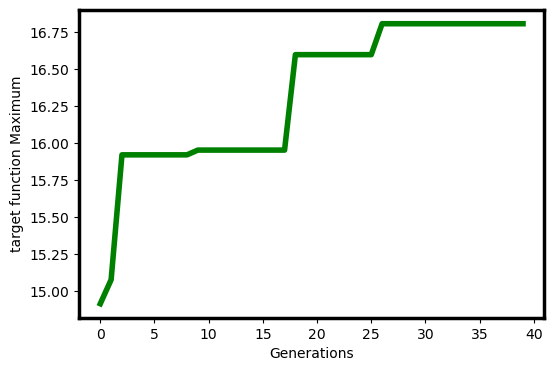

In [47]:
max_values = []
for i in range(40):
    max_values.append(np.nanmax(data_gens_load[i]['y_abs']))

fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(np.arange(40), max_values, linewidth = 4, c = 'g')
ax.set_xlabel('Generations')
ax.set_ylabel('target function Maximum')

plt.savefig('targetfuncmax_main_thompson.png', dpi = 300)

In [86]:
import imageio

# Directory to store images
image_dir = 'plots/'
video_filename = 'predmean_video_take2.gif'
bins = np.arange(0, 22, 1)
# Create images from plots
for i in data_gens.keys():
    data = data_gens[i]
    plt.figure(figsize=(10, 6))
    plt.hist(y0_abs, bins=bins, color='red', alpha=0.3)
    plt.hist(data['pred_mean'], bins=bins, color='blue', alpha=0.5)
    plt.xlim([5, 18])
    plt.ylim([0, 700])
    plt.xlabel('Curl')
    plt.ylabel('Counts')
    plt.title(f'Generation {i}')
    plt.grid(True)
    plt.savefig(f"{image_dir}fitnessplot_{i:03d}.png", dpi = 300)
    plt.close()

# Create a video from images
with imageio.get_writer(video_filename, mode='I', fps=3) as writer:
    for i in range(len(data_gens.keys())):
        image = imageio.imread(f"{image_dir}fitnessplot_{i:03d}.png")
        
        writer.append_data(image)

print("Video creation complete.")

/tmp/ipykernel_2442551/1205850812.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(f"{image_dir}fitnessplot_{i:03d}.png")


Video creation complete.


In [203]:
gen = 8
X_train = data_gens[gen]['X_train']
y_train = data_gens[gen]['y_train']
X = data_gens[gen]['X']
y_abs = data_gens[gen]['y_abs']

rng_key, rng_key_predict = gpax.utils.get_keys()
dkl_BO = gpax.viDKL(900, 2, 'RBF')
dkl_BO.fit(rng_key, X_train, y_train, nn = customMLP, num_steps = 3000)

100%|█| 3000/3000 [00:23<00:00, 129.97it/s, init loss: 65452.6827, avg. loss [28



Inferred GP kernel parameters
k_length         [2.3989 1.7028]
k_scale          14.7428
noise            0.11750000000000001


In [206]:
y_mean_train, y_var_train = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            rng_key_predict, X_train, batch_size=20)
y_std_train = jnp.sqrt(y_var_train)

y_mean, y_var = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            rng_key_predict, X, batch_size=20)
y_std = jnp.sqrt(y_var)

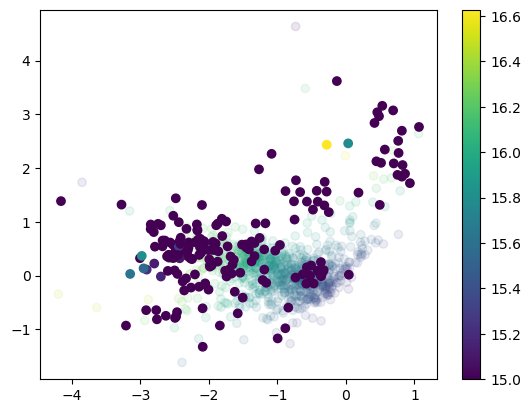

In [207]:
D = dkl_BO.embed(X)
D_train = dkl_BO.embed(X_train)
plt.scatter(D[:,0], D[:, 1], c = y_mean, alpha = 0.1)
plt.scatter(D_train[:,0], D_train[:, 1], c = y_train, vmin = 15)
plt.colorbar()

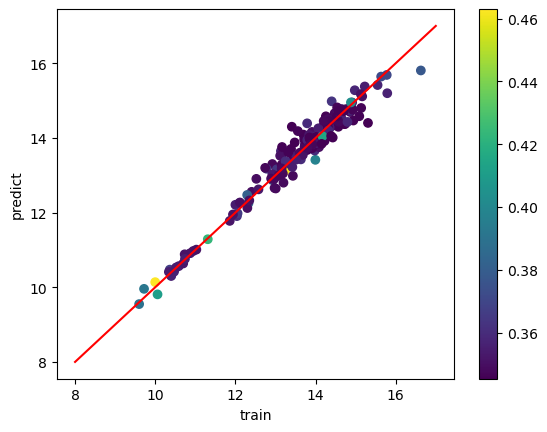

In [208]:
plt.scatter(y_train, y_mean_train, c = y_std_train)
plt.plot(np.linspace(8,17, 100), np.linspace(8,17, 100), c = 'r')
plt.xlabel('train')
plt.ylabel('predict')
plt.colorbar()

In [46]:
np.nanmax(data_gens[9]['y_abs'])

16.368048621781732

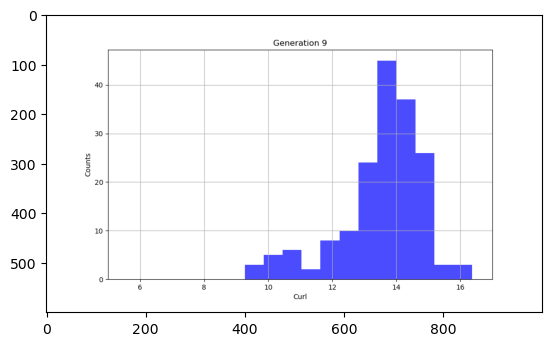

In [30]:
plt.imshow((image))

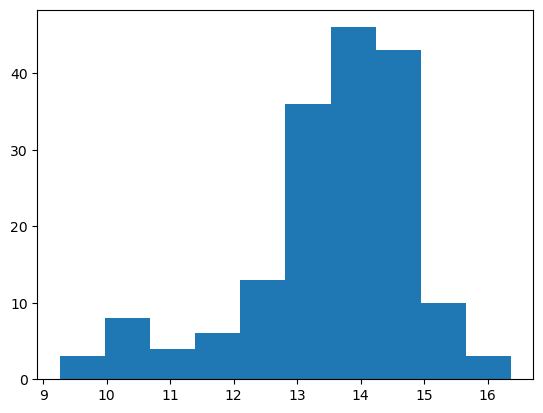

In [37]:
a = plt.hist(data['y_abs'])